In [1]:
import pandas as pd

# 读取 Excel 文件中的所有表格 manything/protein_net/41588_2018_130_MOESM3_ESM.xlsx
file_path = '../manything/protein_net/LGS_gene.xlsx'
# file_path = '../manything/protein_net/41588_2018_130_MOESM6_ESM.xlsx'
sheets = pd.read_excel(file_path, sheet_name=None, header=None)

# 将每个表格存储到单独的 DataFrame
dataframes = {sheet_name: df for sheet_name, df in sheets.items()}
importants = []
# 打印每个 DataFrame 的名称和前几行
for name, df in dataframes.items():
    print(f"表格名称: {name}")
    # print(len(set(df[0].tolist()) & set(pros['preferred_name'].tolist())), len(df[0].tolist()))  # 打印前几行
    importants.append(df[0].tolist())
len(importants), len(importants[0])


表格名称: Sheet1
表格名称: Sheet2
表格名称: Sheet3
表格名称: Sheet4
表格名称: Sheet5
表格名称: Sheet6


(6, 4)

In [2]:
import gseapy as gp
import math
gene_sets = {}
with open("../manything/KEGG_2021_Human.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis

important_GO = [
    "Amino acid metabolism",
    "Neuroactive ligand-receptor interaction",
    "Cytokine-cytokine receptor interaction",
    "Calcium signaling pathway",
    "Synaptic vesicle cycle"
]
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
result = []
number = []
for use_gene in importants:
    sample_result = []
    # use_gene = sample[0] + sample[1] + sample[3]
    # print(len(use_gene))
    number.append(len(use_gene))
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    for GO in important_GO:
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            sample_result.append(-math.log10(p_value))
        else:
            sample_result.append(0)  # 未找到，填充 0
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)
    # if len(result) == 30:
    #     break
# Calculate the average for each GO term in ssss
average_scores = {go: (sum(scores) / len(scores) if scores else 0) for go, scores in ssss.items()}

# Find the top 5 GO terms with the highest average scores
top_5_go = sorted(average_scores.items(), key=lambda item: item[1], reverse=True)[:12]

# Print the results
important_GO = []
for go_term, avg_score in top_5_go:
    print("GO term:", go_term, "Average score:", avg_score)
    important_GO.append(go_term)

GO term: Drug metabolism Average score: 2.9472907086472446
GO term: Retinol metabolism Average score: 2.7470965762945334
GO term: Chemical carcinogenesis Average score: 2.41308638485273
GO term: Metabolism of xenobiotics by cytochrome P450 Average score: 2.41308638485273
GO term: Linoleic acid metabolism Average score: 1.948626317301174
GO term: Steroid hormone biosynthesis Average score: 1.9184722695813246
GO term: Bile secretion Average score: 1.7220615460264466
GO term: Ascorbate and aldarate metabolism Average score: 1.3669876760194413
GO term: Pentose and glucuronate interconversions Average score: 1.337429468889434
GO term: Porphyrin and chlorophyll metabolism Average score: 1.27202632757523
GO term: Serotonergic synapse Average score: 1.240943577621097
GO term: Arachidonic acid metabolism Average score: 1.0526119616926712


In [3]:
import networkx as nx
G = nx.read_gml('../manything/graph_ppi_only_p.gml')

In [9]:
data = sorted(average_scores.items(), key=lambda item: item[1], reverse=True)[:12]

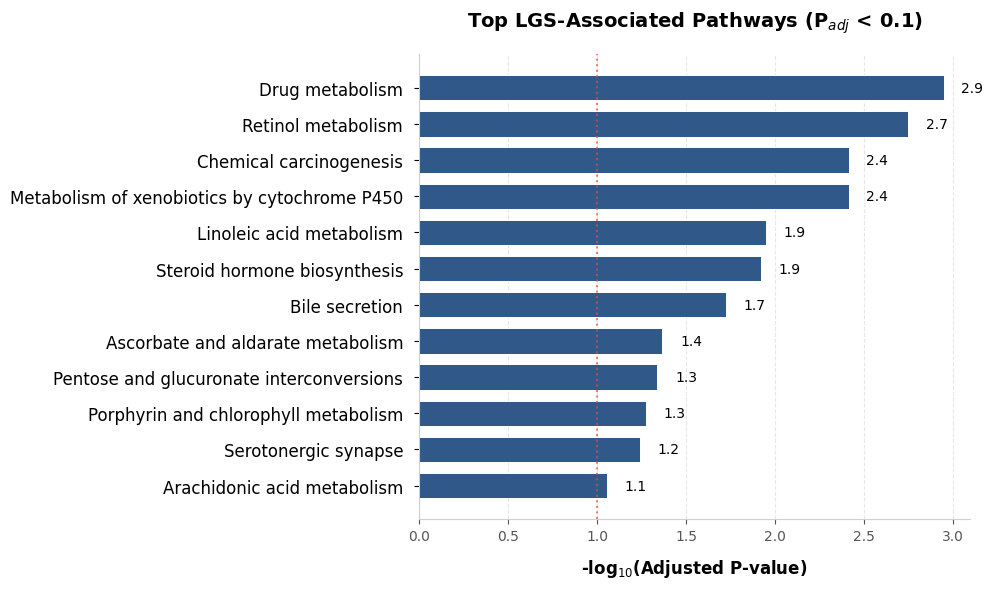

In [10]:
labels, values = zip(*data)
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Custom colors
main_color = '#305989'  # Your requested navy blue
highlight_color = '#4c8cbd'  # Lighter complementary blue

# Create horizontal bars with improved formatting
bars = ax.barh(labels, values, 
               color=main_color,
               height=0.7,  # Slightly thicker bars
               edgecolor='white',
               linewidth=0.7)

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.1,  # x-position (right of bar)
            bar.get_y() + bar.get_height()/2,  # y-position (center of bar)
            f'{width:.1f}',  # Formatted value
            va='center',
            ha='left',
            fontsize=10)

# Styling improvements
ax.set_xlabel('-log$_{10}$(Adjusted P-value)', 
              fontsize=12, labelpad=10, fontweight='bold')
ax.set_title('Top LGS-Associated Pathways (P$_{adj}$ < 0.1)', 
             fontsize=14, pad=20, fontweight='bold')

# Adjust spines (borders) for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#d0d0d0')
ax.spines['bottom'].set_color('#d0d0d0')

# Grid and tick formatting
ax.xaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)  # Grid behind bars

# Improved y-axis labels (choose either OPTION 1 or 2 below)

# OPTION 1: Larger font + black (recommended)
ax.tick_params(axis='y', which='major', 
               labelsize=12,  # Increased from default 10
               colors='black',  # Pure black
               pad=8)

# OPTION 2: Bold font + black (alternative)
# ax.tick_params(axis='y', which='major',
#                colors='black',
#                labelsize=11,
#                pad=8)
# for label in ax.get_yticklabels():
#     label.set_fontweight('bold')

ax.tick_params(axis='x', colors='#555555')  # Keep x-axis ticks gray

# Add threshold line
threshold = 1
ax.axvline(x=threshold, color='#e74c3c', linestyle=':', alpha=0.7, linewidth=1.5)

# Invert y-axis to show highest value at top
ax.invert_yaxis()

plt.savefig('../manything/LGS_pvalue.png', dpi=500, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [3]:
import gseapy as gp
import math
gene_sets = {}
import pandas as pd
# samples = pd.read_csv('../manything/ASD_use.csv')
# samples = samples[samples['PrimaryPhenotype'] == 'Autism (ASD)']
# samples['PrimaryPhenotype'].value_counts(), samples.shape
with open("../manything/KEGG_2021_Human.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis

# important_GO = [
#     "Amino acid metabolism",
#     "Neuroactive ligand-receptor interaction",
#     "Cytokine-cytokine receptor interaction",
#     "Calcium signaling pathway",
#     "Synaptic vesicle cycle"
# ]
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
result = []
number = []
number2 = []
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
buer = []

nnnn = 30
import json
with open('../manything/disease_onlyp_LGS.json', 'r') as f:
    CDH_list = json.load(f)

# for index, sample in enumerate(CDH_list):
#     use_gene = list(G.neighbors(sample['mutation']))
#     # if any(item not in sample['nab'][0]+sample['nab'][1]+sample['nab'][2]+sample['nab'][3] for item in use_gene):
#     #     print('err0')
#     #     break

#     for class_index in range(len(sample['nab'])):
#         CDH_list[index]['nab'][class_index] = [gene for gene in CDH_list[index]['nab'][class_index] if gene in use_gene]

for idx, sample in enumerate(CDH_list):
    if len(buer) == nnnn + 1:
        break
    sample_result = []
    samplep = sample['nab']
    use_gene = samplep[0] + samplep[1] + samplep[3]# + [samples.iloc[idx]['Gene.refGene']]
    # print(len(use_gene))
    geneuse = sample['mutation']
    number.append(len(use_gene))
    number2.append(len(samplep[0] + samplep[1] + samplep[2] + samplep[3]))
    if len(use_gene) == 0:
        result.append([0 for _ in range(len(important_GO))])

        sample_buer = []
        # print(len(use_gene))
        for GO in important_GO:
            
            if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
                sample_buer.append(1)
                print(geneuse, GO, idx)
            else:
                sample_buer.append(0)  # 未找到，填充 0
        buer.append(sample_buer)
        
        continue
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    if len(pandas_use) == 0:
        print(idx)
        result.append([0 for _ in range(len(important_GO))])
        sample_buer = []
        for GO in important_GO:
            
            if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
                sample_buer.append(1)
                print(geneuse, GO, idx)
            else:
                sample_buer.append(0)  # 未找到，填充 0
        buer.append(sample_buer)



        
        continue
    for GO in important_GO:
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            
            sample_result.append(-math.log10(p_value))

            # p_value = item['Overlap'].values[0]  # 提取 P-value
            
            # sample_result.append(int(p_value.split('/')[0]))
        else:
            sample_result.append(0)  # 未找到，填充 0
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)


    sample_buer = []
    # print(len(use_gene))
    for GO in important_GO:
        
        if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
            sample_buer.append(1)
            print(geneuse, GO, idx)
        else:
            sample_buer.append(0)  # 未找到，填充 0
    buer.append(sample_buer)
    if len(buer) == nnnn:
        break

GABRB3 Serotonergic synapse 15
CACNA1A Chemical carcinogenesis 24
CACNA1A Serotonergic synapse 24


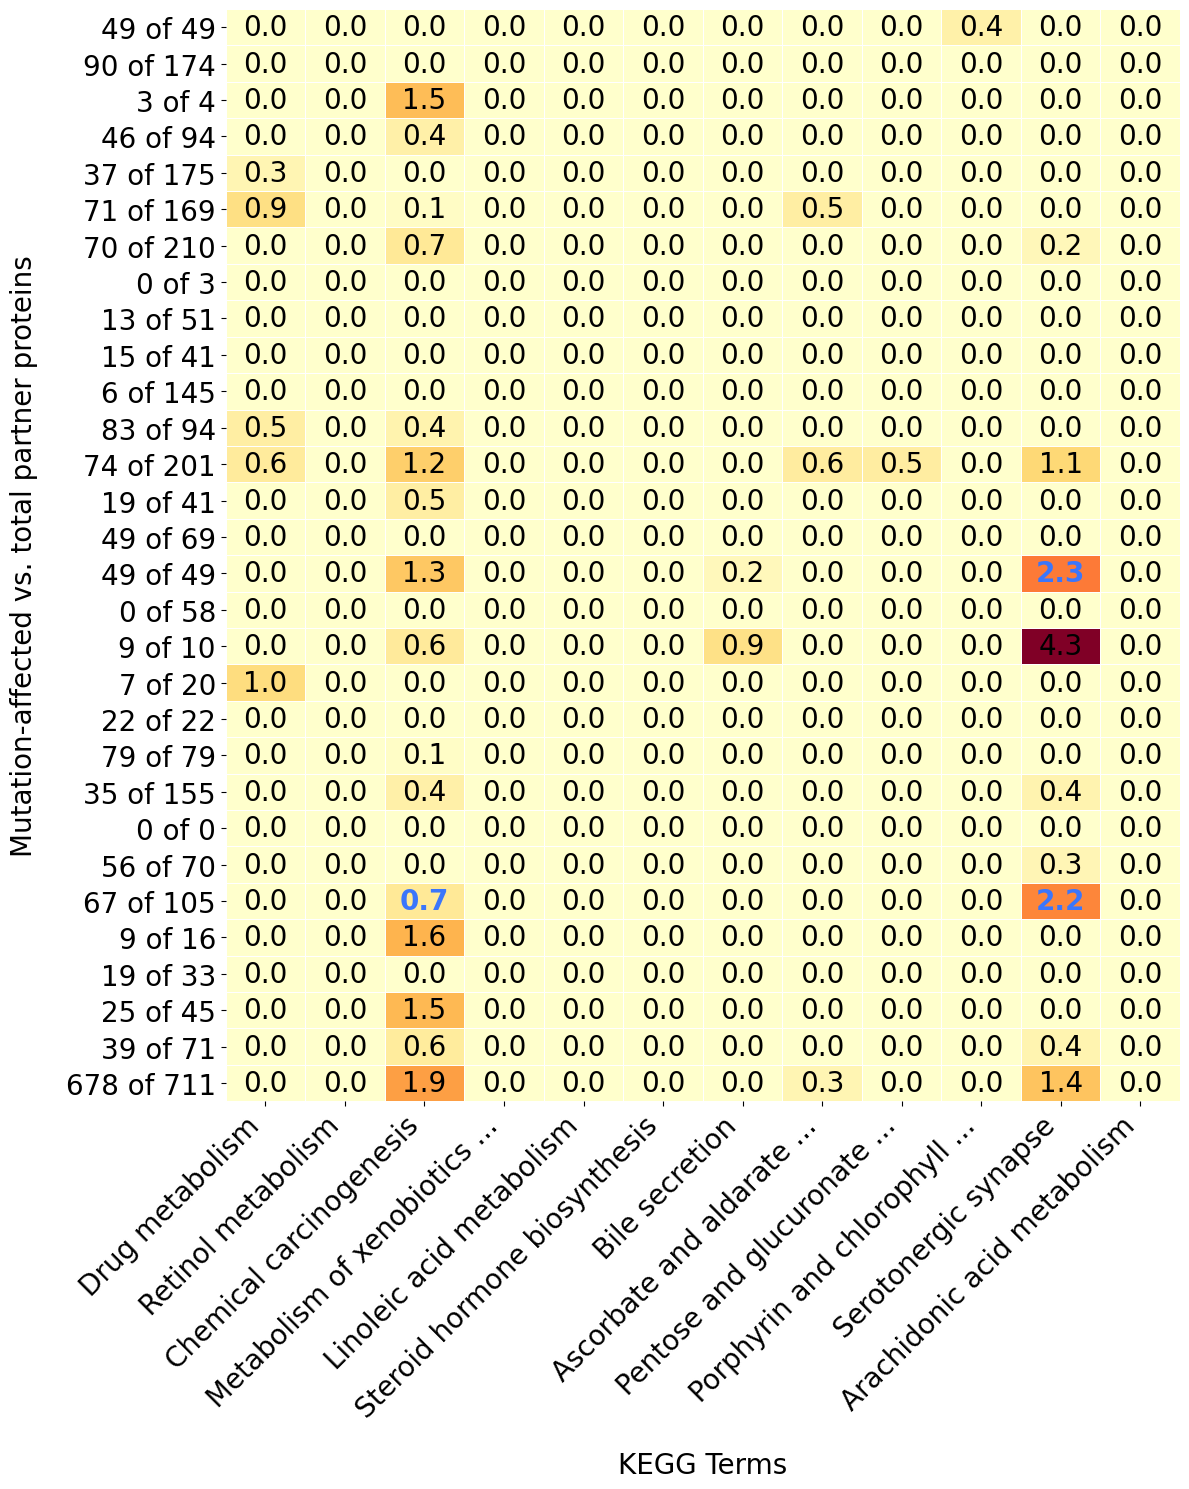

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume result is your data matrix (rows=samples, cols=GO/KEGG Terms)
start = 0
data = np.array(result[start:])  # Transposed data (rows=Terms, cols=samples)

def truncate_label(label, max_words=3):
    words = label.split()
    if len(words) > max_words:
        return ' '.join(words[:max_words]) + ' ...'
    return label


# --- Dynamic height calculation ---
base_height = 6  
term_height = 0.3  
dynamic_height = base_height + term_height * data.shape[0]  
fontsize = 20  # Unified font size for all elements

# Create figure with dynamic height
plt.figure(figsize=(12, dynamic_height))

# Draw heatmap with font control
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap='YlOrRd',
    cbar=False,
    annot_kws={"size": fontsize, "color": "black"},  # Control annotation font
    yticklabels=[f"{number[i]} of {number2[i]}" for i in range(len(result[start:]))],
    xticklabels=[truncate_label(label) for label in important_GO[start:]],
    linewidths=0.5
)

# Adjust axis labels
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    ha='right',
    fontsize=fontsize  # X-tick labels
)
ax.set_yticklabels(
    ax.get_yticklabels(), 
    fontsize=fontsize,  # Y-tick labels
    rotation=0
)

# Set axis titles
ax.set_xlabel(
    "KEGG Terms", 
    labelpad=fontsize, 
    fontsize=fontsize  # X-axis title
)
ax.set_ylabel(
    "Mutation-affected vs. total partner proteins", 
    labelpad=fontsize, 
    fontsize=fontsize  # Y-axis title
)

# Highlight specific cells
for text in ax.texts:
    row, col = map(int, text.get_position())
    if buer[start:][col][row] == 1:
        text.set_color('#3b76fb')
        text.set_weight('bold')
        text.set_size(fontsize)  # Ensure highlighted text matches size

# Add colorbar with matching font
cbar = ax.figure.colorbar(ax.collections[0])
cbar.ax.tick_params(labelsize=fontsize)  # Colorbar tick labels

ax.collections[0].colorbar.remove() 

plt.savefig('../manything/LGS_hotplot.png', dpi=500, bbox_inches='tight')
plt.tight_layout()
plt.show()

/tmp/ipykernel_84416/4022643146.py:77: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


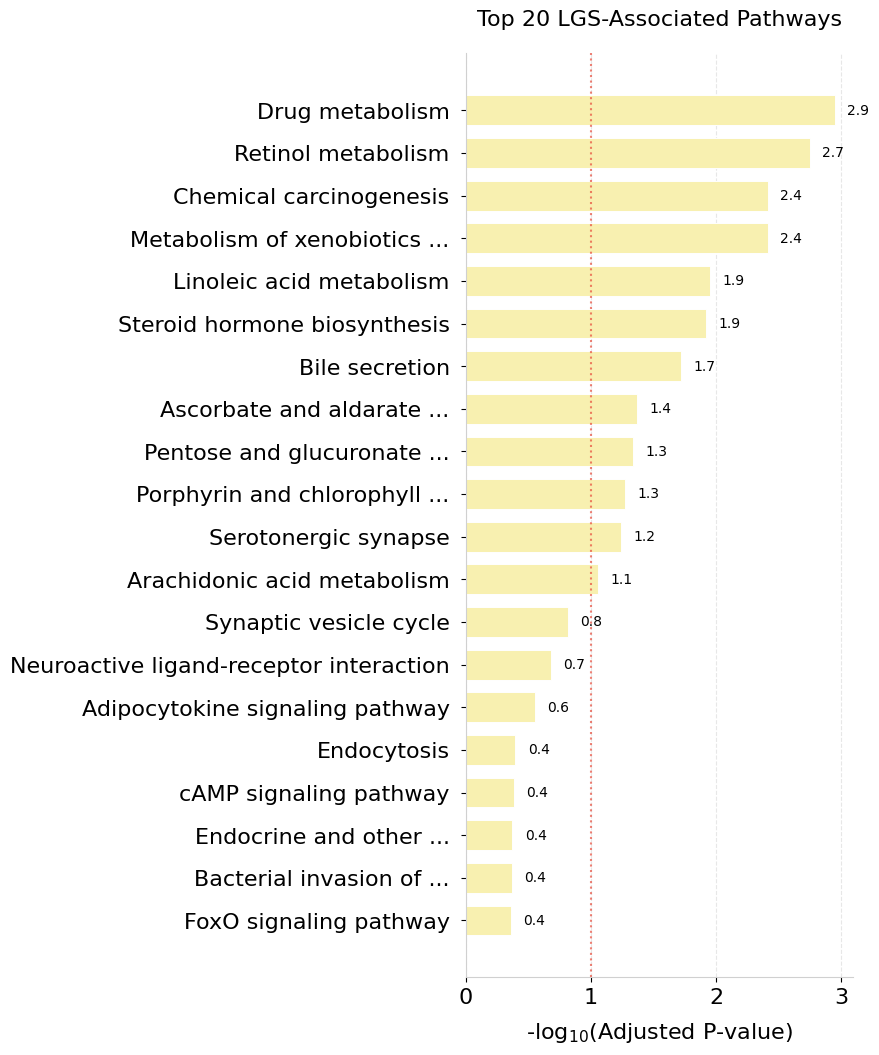

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data_hot = sorted(average_scores.items(), key=lambda item: item[1], reverse=True)[:20]
labels, values = zip(*data_hot)
plt.figure(figsize=(5, 12))
ax = plt.gca()
def truncate_label(label, max_words=3):
    words = label.split()
    if len(words) > max_words:
        return ' '.join(words[:max_words]) + ' ...'
    return label
# Custom colors
frontsize = 16
main_color = '#F8F0B0'  # Your requested navy blue
highlight_color = '#4c8cbd'  # Lighter complementary blue

# Create horizontal bars with improved formatting
bars = ax.barh([truncate_label(e) for e in labels], values, 
               color=main_color,
               height=0.7,  # Slightly thicker bars
               edgecolor='white',
               linewidth=0.7)

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.1,  # x-position (right of bar)
            bar.get_y() + bar.get_height()/2,  # y-position (center of bar)
            f'{width:.1f}',  # Formatted value
            va='center',
            ha='left',
            fontsize=10)

# Styling improvements
ax.set_xlabel('-log$_{10}$(Adjusted P-value)', 
              fontsize = frontsize, labelpad=10)
ax.set_title('Top 20 LGS-Associated Pathways', 
             fontsize = frontsize, pad=20)

# Adjust spines (borders) for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#d0d0d0')
ax.spines['bottom'].set_color('#d0d0d0')

# Grid and tick formatting
ax.xaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)  # Grid behind bars

# Improved y-axis labels (choose either OPTION 1 or 2 below)

# OPTION 1: Larger font + black (recommended)
ax.tick_params(axis='y', which='major', 
               labelsize=frontsize,  # Increased from default 10
               colors='black',  # Pure black
               pad=8)

# OPTION 2: Bold font + black (alternative)
# ax.tick_params(axis='y', which='major',
#                colors='black',
#                labelsize=11,
#                pad=8)
# for label in ax.get_yticklabels():
#     label.set_fontweight('bold')

ax.tick_params(axis='x', labelsize=frontsize)  # Keep x-axis ticks gray

# Add threshold line
threshold = 1
ax.axvline(x=threshold, color='#e74c3c', linestyle=':', alpha=0.7, linewidth=1.5)

# Invert y-axis to show highest value at top
ax.invert_yaxis()

plt.savefig('../manything/LGS_pvalue.png', dpi=500, bbox_inches='tight')
plt.tight_layout()
plt.show()

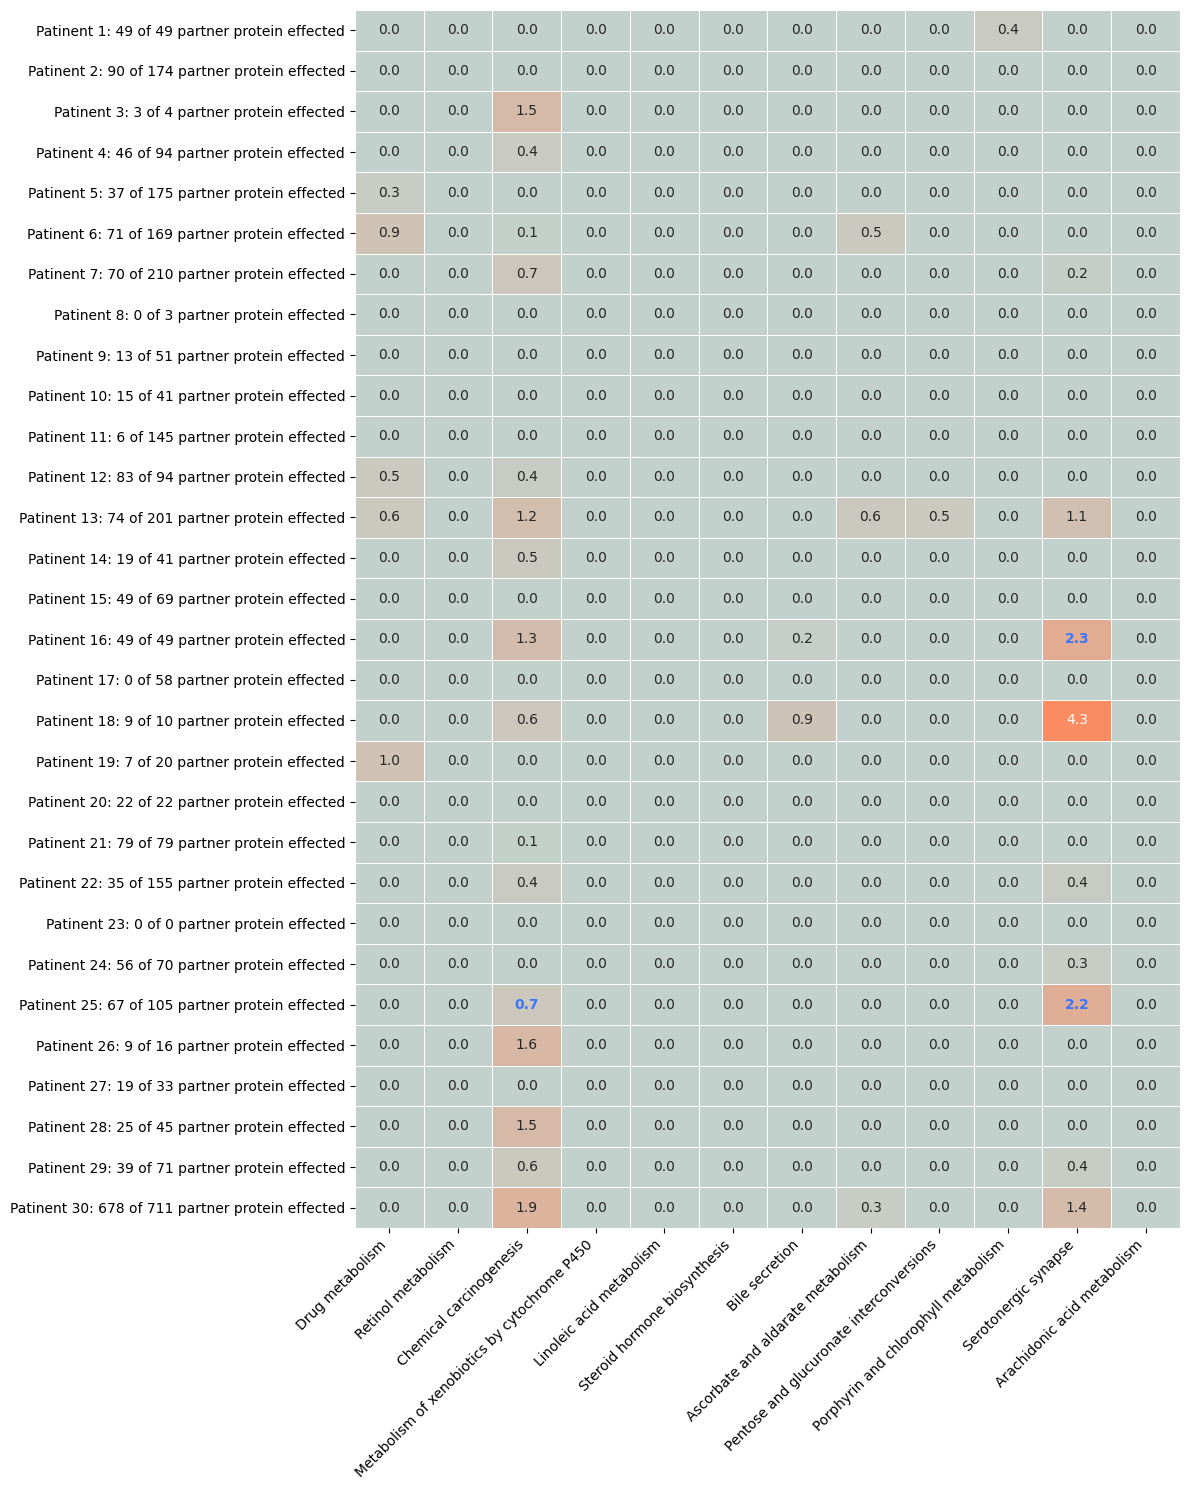

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# 假设 result 是原始数据（行=样本，列=GO/KEGG Terms）
start = 0
data = np.array(result[start:])  # 转置数据（行=Terms，列=样本）

# --- 自定义色板 (白色 -> #fc8d62) ---
colors = ["#c3d1cc", "#fc8d62"]  # 从白色过渡到目标颜色
custom_cmap = LinearSegmentedColormap.from_list("custom_orange", colors)

# --- 自适应高度计算 ---
# 基础高度（每个Term分配0.3英寸，最小6英寸）
base_height = 6  
term_height = 0.3  # 每个Term的高度（英寸）
dynamic_height = base_height + term_height * data.shape[0]  # 根据行数调整

# 创建画布（宽度固定，高度动态）
plt.figure(figsize=(12, dynamic_height))

# 绘制热图（使用自定义色板）
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap=custom_cmap,  # 使用自定义色板
    cbar=False,
    yticklabels=[f"Patinent {i+1}: {number[i]} of {number2[i]} partner protein effected" for i in range(len(result[start:]))],
    xticklabels=important_GO[start:],  # 直接使用GO/KEGG名称列表
    linewidths=0.5  # 添加细线分隔单元格
)

# 调整标签样式
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    ha='right',
    fontsize=10
)
ax.set_yticklabels(
    ax.get_yticklabels(), 
    fontsize=10,
    rotation=0  # 保证纵轴标签水平显示
)

# 设置轴标签
# plt.xlabel("KEGG Terms", labelpad=10)
# plt.ylabel("Samples", labelpad=10)

# 高亮特定单元格（根据buer矩阵）
for text in ax.texts:
    row, col = map(int, text.get_position())
    if buer[start:][col][row] == 1:  # 注意转置后行列索引变化
        text.set_color('#3b76fb')
        text.set_weight('bold')
plt.savefig('../manything/LGS_hotplot.png', dpi=500, bbox_inches='tight')
# 自动调整布局
plt.tight_layout()
plt.show()

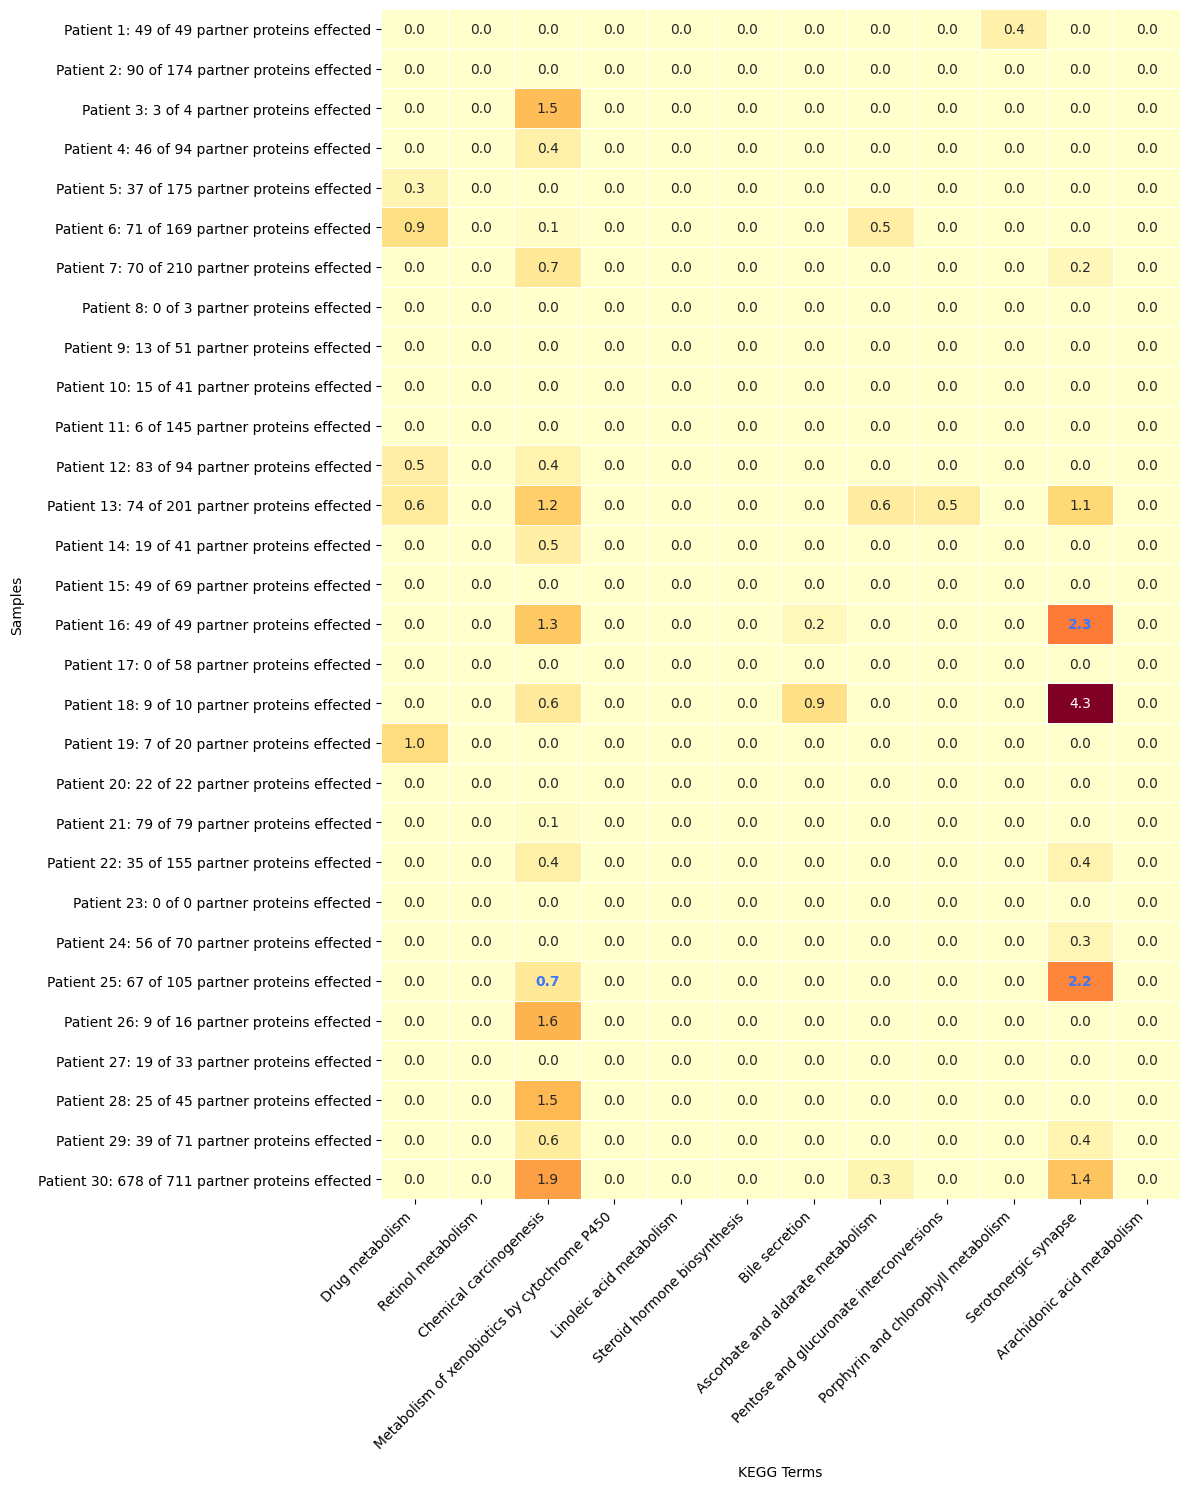

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 result 是原始数据（行=样本，列=GO/KEGG Terms）
start = 0
data = np.array(result[start:])  # 转置数据（行=Terms，列=样本）

# --- 自适应高度计算 ---
# 基础高度（每个Term分配0.3英寸，最小6英寸）
base_height = 6  
term_height = 0.3  # 每个Term的高度（英寸）
dynamic_height = base_height + term_height * data.shape[0]  # 根据行数调整

# 创建画布（宽度固定，高度动态）
plt.figure(figsize=(12, dynamic_height))

# 绘制热图（使用黄到红的经典热图颜色）
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap='YlOrRd',  # 使用黄到红的经典热图颜色
    cbar=False,
    yticklabels=[f"Patient {i+1}: {number[i]} of {number2[i]} partner proteins effected" for i in range(len(result[start:]))],
    xticklabels=important_GO[start:],  # 直接使用GO/KEGG名称列表
    linewidths=0.5  # 添加细线分隔单元格
)

# 调整标签样式
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    ha='right',
    fontsize=10
)
ax.set_yticklabels(
    ax.get_yticklabels(), 
    fontsize=10,
    rotation=0  # 保证纵轴标签水平显示
)

# 设置轴标签
plt.xlabel("KEGG Terms", labelpad=10)
plt.ylabel("Samples", labelpad=10)

# 高亮特定单元格（根据buer矩阵）
for text in ax.texts:
    row, col = map(int, text.get_position())
    if buer[start:][col][row] == 1:  # 注意转置后行列索引变化
        text.set_color('#3b76fb')
        text.set_weight('bold')

plt.savefig('../manything/LGS_hotplot.png', dpi=500, bbox_inches='tight')
# 自动调整布局
plt.tight_layout()
plt.show()

SCARB1 Bile secretion 3


2025-04-28 02:47:37,190 [ERROR] No hits returned for all input gene sets!


11


2025-04-28 02:47:38,511 [ERROR] No hits returned for all input gene sets!


19


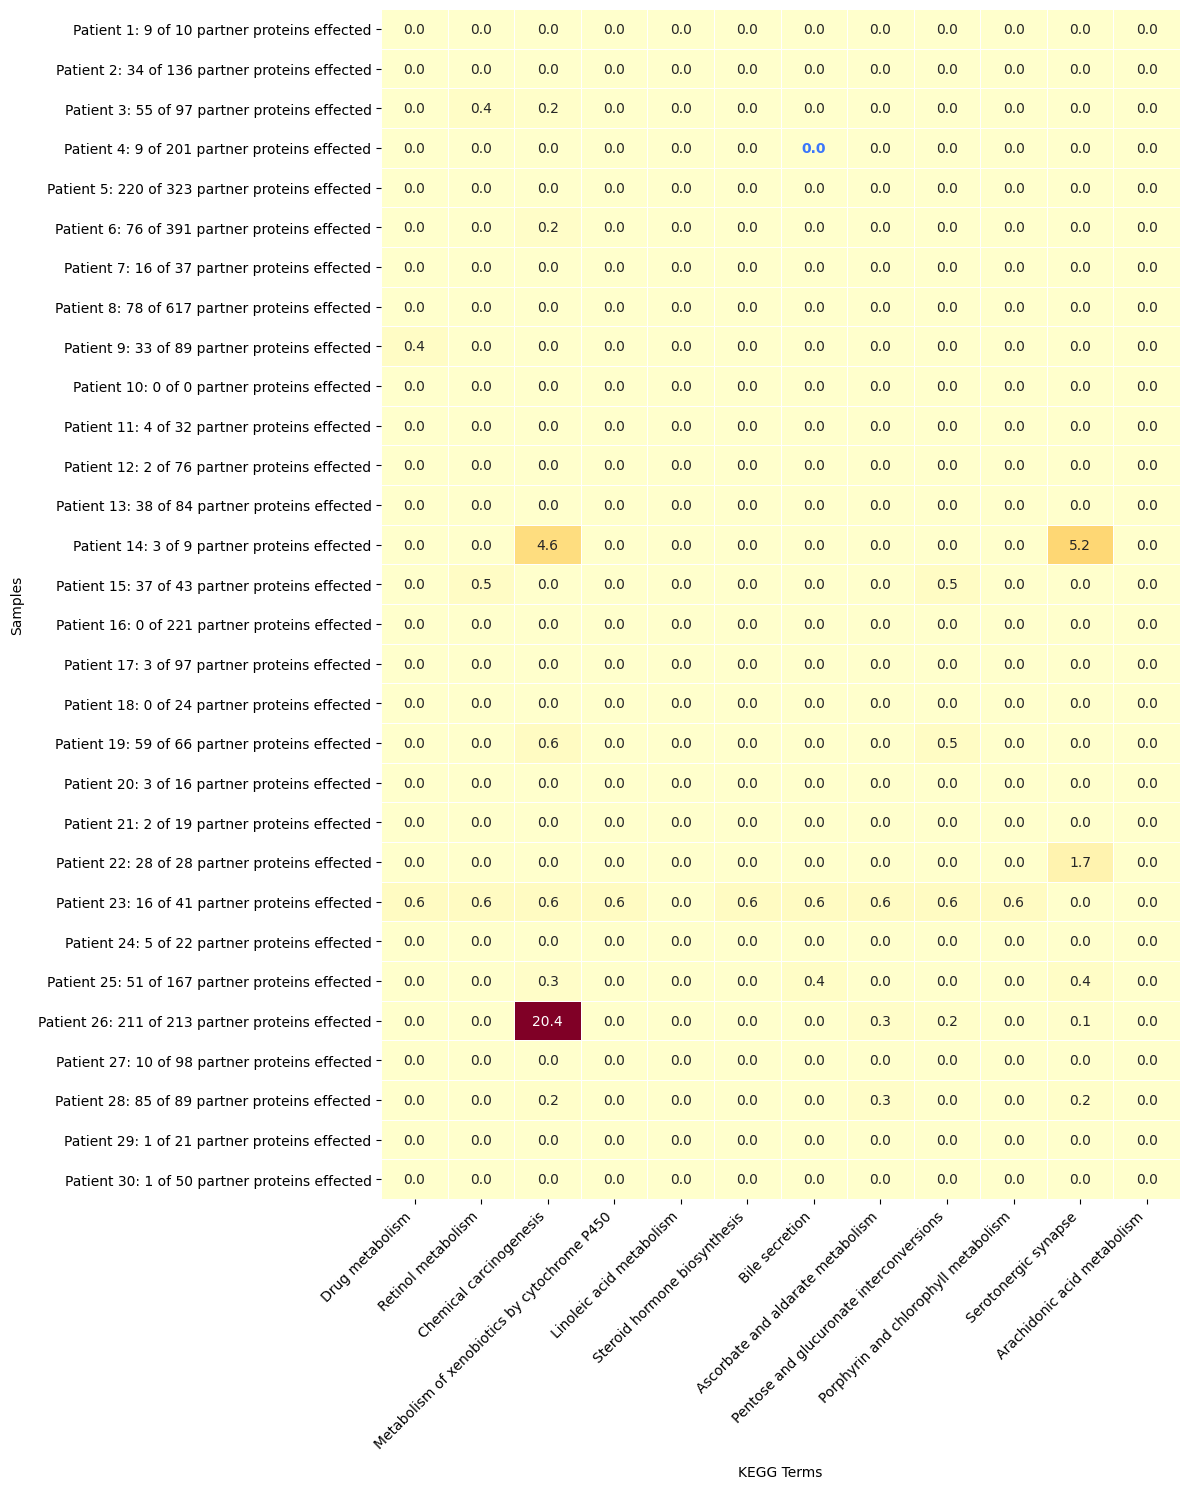

In [20]:
import gseapy as gp
import math
gene_sets = {}
import pandas as pd
# samples = pd.read_csv('../manything/ASD_use.csv')
# samples = samples[samples['PrimaryPhenotype'] == 'Autism (ASD)']
# samples['PrimaryPhenotype'].value_counts(), samples.shape
with open("../manything/KEGG_2021_Human.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis

# important_GO = [
#     "Amino acid metabolism",
#     "Neuroactive ligand-receptor interaction",
#     "Cytokine-cytokine receptor interaction",
#     "Calcium signaling pathway",
#     "Synaptic vesicle cycle"
# ]
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
result = []
number = []
numberb = []

ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
buer = []

nnnn = 30
import json
with open('../manything/disease_onlyp_Control2.json', 'r') as f:
    CDH_list = json.load(f)

# for index, sample in enumerate(CDH_list):
#     use_gene = list(G.neighbors(sample['mutation']))
#     # if any(item not in sample['nab'][0]+sample['nab'][1]+sample['nab'][2]+sample['nab'][3] for item in use_gene):
#     #     print('err0')
#     #     break

#     for class_index in range(len(sample['nab'])):
#         CDH_list[index]['nab'][class_index] = [gene for gene in CDH_list[index]['nab'][class_index] if gene in use_gene]

for idx, sample in enumerate(CDH_list):
    if len(buer) == nnnn + 1:
        break
    sample_result = []
    samplep = sample['nab']
    use_gene = samplep[0] + samplep[1] + samplep[3]# + [samples.iloc[idx]['Gene.refGene']]
    # print(len(use_gene))
    geneuse = sample['mutation']
    number.append(len(use_gene))
    numberb.append(len(samplep[0] + samplep[1] + samplep[2] + samplep[3]))
    if len(use_gene) == 0:
        result.append([0 for _ in range(len(important_GO))])

        sample_buer = []
        # print(len(use_gene))
        for GO in important_GO:
            
            if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
                sample_buer.append(1)
                print(geneuse, GO, idx)
            else:
                sample_buer.append(0)  # 未找到，填充 0
        buer.append(sample_buer)
        
        continue
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    if len(pandas_use) == 0:
        print(idx)
        result.append([0 for _ in range(len(important_GO))])
        sample_buer = []
        for GO in important_GO:
            
            if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
                sample_buer.append(1)
                print(geneuse, GO, idx)
            else:
                sample_buer.append(0)  # 未找到，填充 0
        buer.append(sample_buer)



        
        continue
    for GO in important_GO:
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            
            sample_result.append(-math.log10(p_value))

            # p_value = item['Overlap'].values[0]  # 提取 P-value
            
            # sample_result.append(int(p_value.split('/')[0]))
        else:
            sample_result.append(0)  # 未找到，填充 0
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)


    sample_buer = []
    # print(len(use_gene))
    for GO in important_GO:
        
        if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
            sample_buer.append(1)
            print(geneuse, GO, idx)
        else:
            sample_buer.append(0)  # 未找到，填充 0
    buer.append(sample_buer)
    if len(buer) == nnnn:
        break

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 result 是原始数据（行=样本，列=GO/KEGG Terms）
start = 0
data2 = np.array(result[start:])  # 转置数据（行=Terms，列=样本）

# --- 自适应高度计算 ---
# 基础高度（每个Term分配0.3英寸，最小6英寸）
base_height = 6  
term_height = 0.3  # 每个Term的高度（英寸）
dynamic_height = base_height + term_height * data.shape[0]  # 根据行数调整

# 创建画布（宽度固定，高度动态）
plt.figure(figsize=(12, dynamic_height))

# 绘制热图（使用黄到红的经典热图颜色）
ax = sns.heatmap(
    data2,
    annot=True,
    fmt=".1f",
    cmap='YlOrRd',  # 使用黄到红的经典热图颜色
    cbar=False,
    yticklabels=[f"Patient {i+1}: {number[i]} of {numberb[i]} partner proteins effected" for i in range(len(result[start:]))],
    xticklabels=important_GO[start:],  # 直接使用GO/KEGG名称列表
    linewidths=0.5  # 添加细线分隔单元格
)

# 调整标签样式
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    ha='right',
    fontsize=10
)
ax.set_yticklabels(
    ax.get_yticklabels(), 
    fontsize=10,
    rotation=0  # 保证纵轴标签水平显示
)

# 设置轴标签
plt.xlabel("KEGG Terms", labelpad=10)
plt.ylabel("Samples", labelpad=10)

# 高亮特定单元格（根据buer矩阵）
for text in ax.texts:
    row, col = map(int, text.get_position())
    if buer[start:][col][row] == 1:  # 注意转置后行列索引变化
        text.set_color('#3b76fb')
        text.set_weight('bold')

plt.savefig('../manything/Control_LGS_hotplot.png', dpi=500, bbox_inches='tight')
# 自动调整布局
plt.tight_layout()
plt.show()

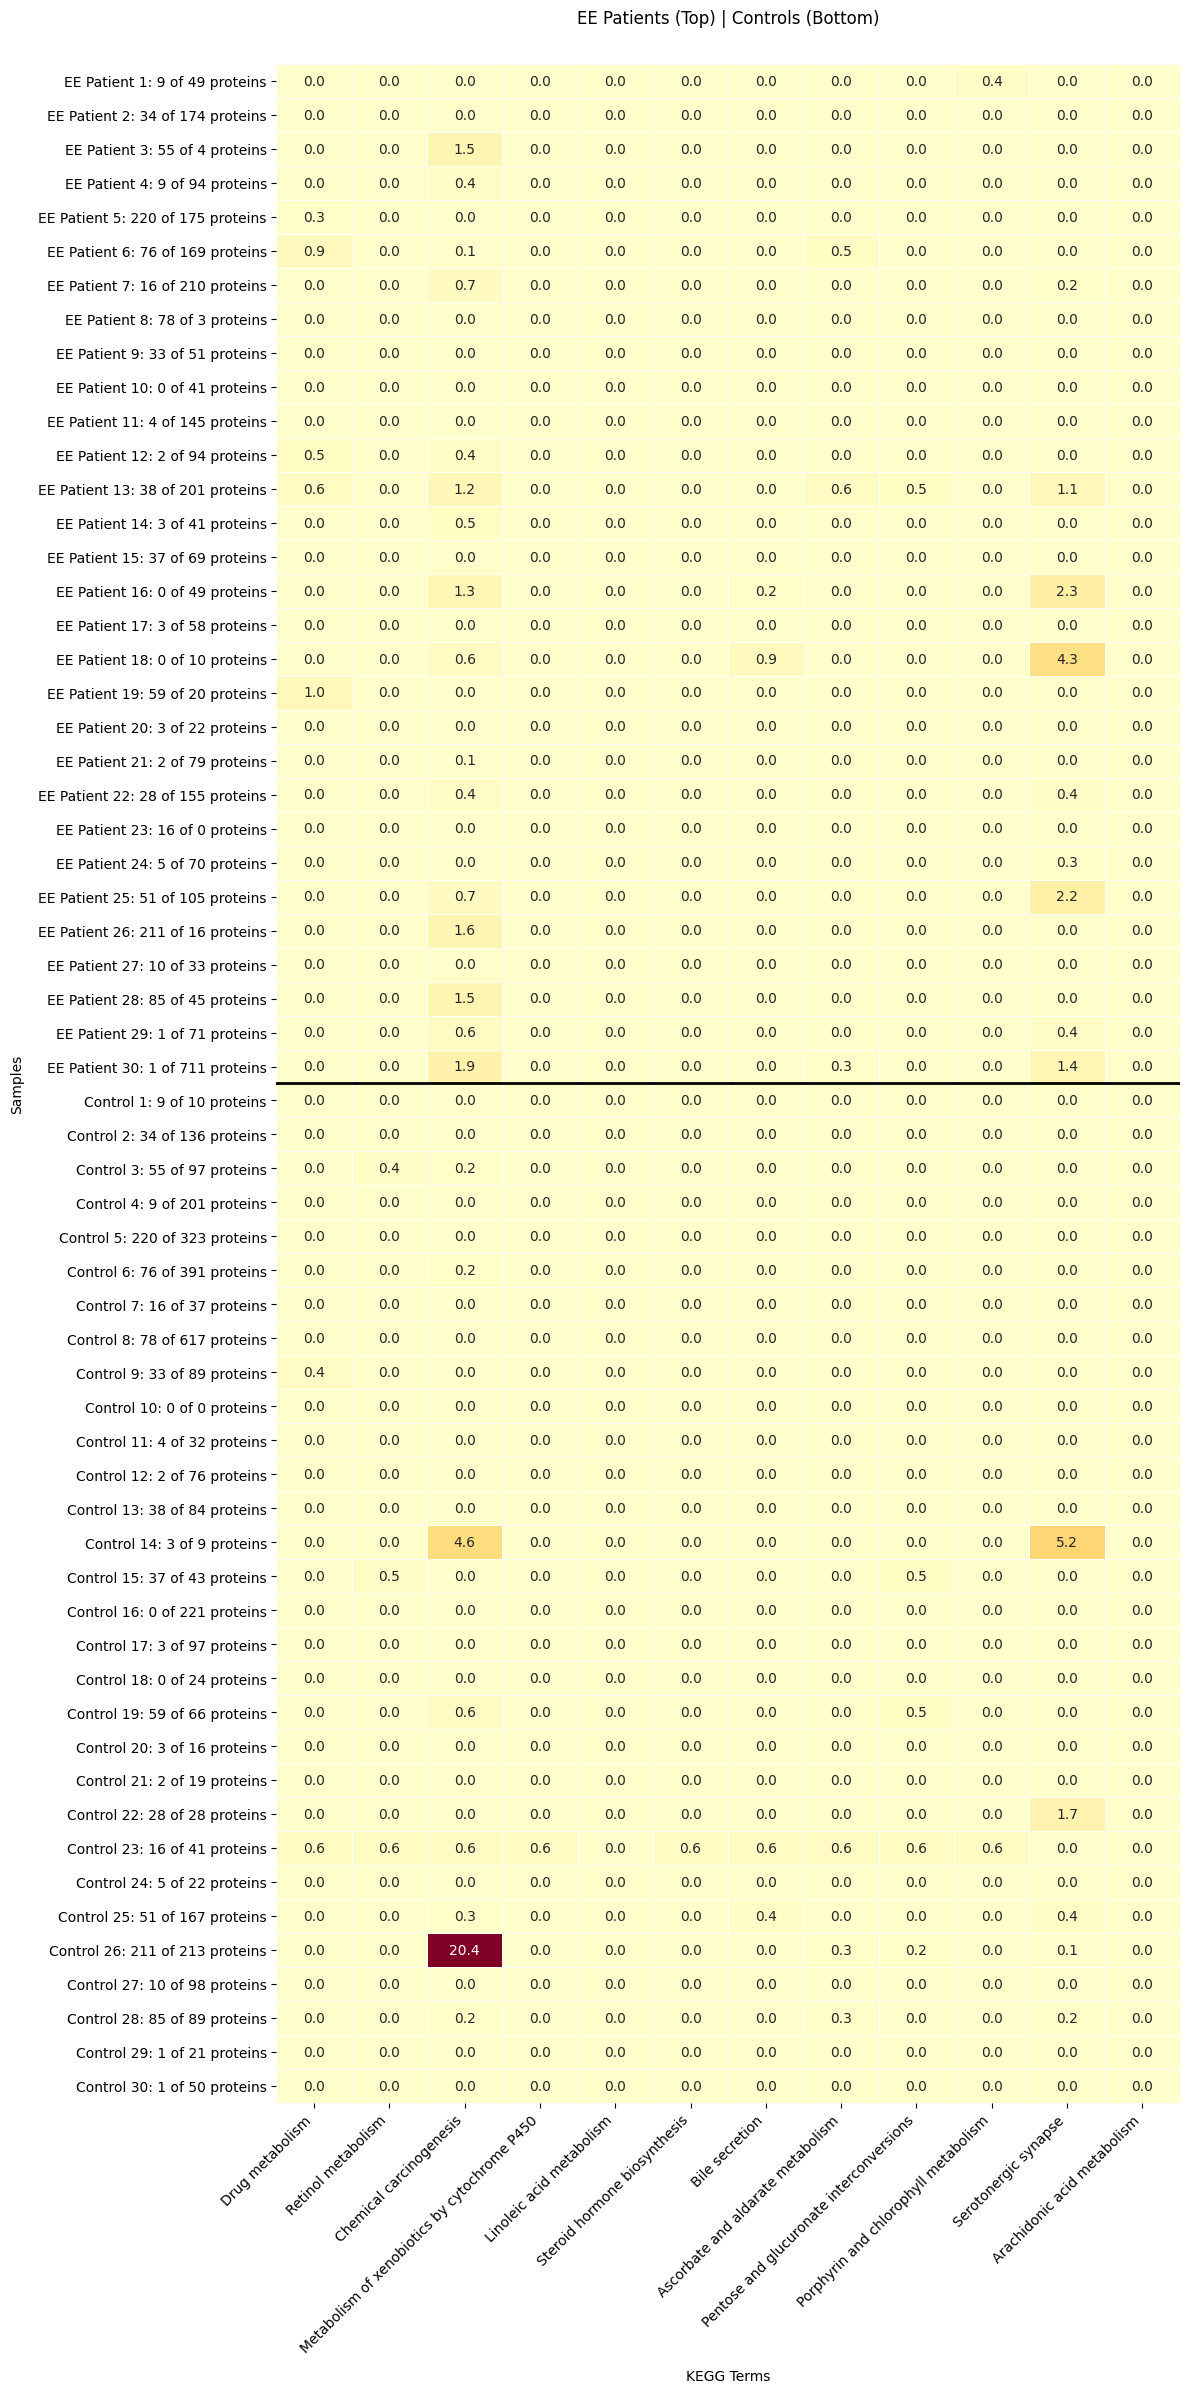

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设已经得到了data和data2两个热图数据矩阵
# data 是第一个热图的数据 (EE_hotplot)
# data2 是第二个热图的数据 (Control_hotplot)

# 合并数据矩阵
combined_data = np.vstack((data[:30], data2[:30]))  # 各取前30行

# 合并其他相关数据
combined_number = number[:30] + number[:30]  # 样本数量信息
combined_number2 = number2[:30] + numberb[:30]  # 总蛋白数量信息
combined_buer = buer[:30] + buer[:30]  # 高亮信息

# 创建样本标签
ee_labels = [f"EE Patient {i+1}: {number[i]} of {number2[i]} proteins" for i in range(30)]
control_labels = [f"Control {i+1}: {number[i]} of {numberb[i]} proteins" for i in range(30)]
combined_labels = ee_labels + control_labels

# --- 自适应高度计算 ---
base_height = 6  
term_height = 0.3  
dynamic_height = base_height + term_height * combined_data.shape[0]

# 创建画布
plt.figure(figsize=(12, dynamic_height))

# 绘制合并热图
ax = sns.heatmap(
    combined_data,
    annot=True,
    fmt=".1f",
    cmap='YlOrRd',
    cbar=False,
    yticklabels=combined_labels,
    xticklabels=important_GO,
    linewidths=0.5
)

# 调整标签样式
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    ha='right',
    fontsize=10
)
ax.set_yticklabels(
    ax.get_yticklabels(), 
    fontsize=10,
    rotation=0
)

# 设置轴标签
plt.xlabel("KEGG Terms", labelpad=10)
plt.ylabel("Samples", labelpad=10)

# 添加分隔线
ax.axhline(30, color='black', linewidth=2)

# 高亮特定单元格
for text in ax.texts:
    row, col = map(int, text.get_position())
    if row < 30:  # EE部分
        if buer[row] == 1:
            text.set_color('#3b76fb')
            text.set_weight('bold')
    else:  # Control部分
        if buer[row-30] == 1:
            text.set_color('#3b76fb')
            text.set_weight('bold')

# 添加图例说明
plt.text(0.5, 1.02, 'EE Patients (Top) | Controls (Bottom)', 
         transform=ax.transAxes, ha='center', fontsize=12)

plt.savefig('../manything/Combined_hotplot.png', dpi=500, bbox_inches='tight')
plt.tight_layout()
plt.show()

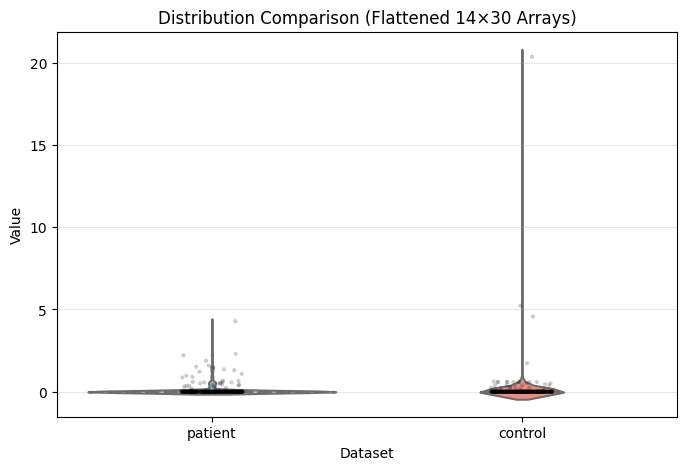

In [8]:
flat_data = data.flatten()    # 420个元素
flat_data2 = data2.flatten()  # 420个元素

# 合并为DataFrame
import pandas as pd
df = pd.DataFrame({
    'Value': np.concatenate([flat_data, flat_data2]),
    'Dataset': ['patient'] * len(flat_data) + ['control'] * len(flat_data2)
})

# 绘制对比小提琴图
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df,
    x='Dataset',
    y='Value',
    palette={'patient': 'skyblue', 'control': 'salmon'},
    inner='quartile',  # 显示四分位数线
    bw=0.2            # 控制平滑度
)

# 添加统计标记
sns.stripplot(
    data=df,
    x='Dataset',
    y='Value',
    color='black',
    alpha=0.2,
    jitter=True,
    size=3
)

plt.title('Distribution Comparison (Flattened 14×30 Arrays)')
plt.ylabel('Value')
plt.grid(axis='y', alpha=0.3)
plt.show()

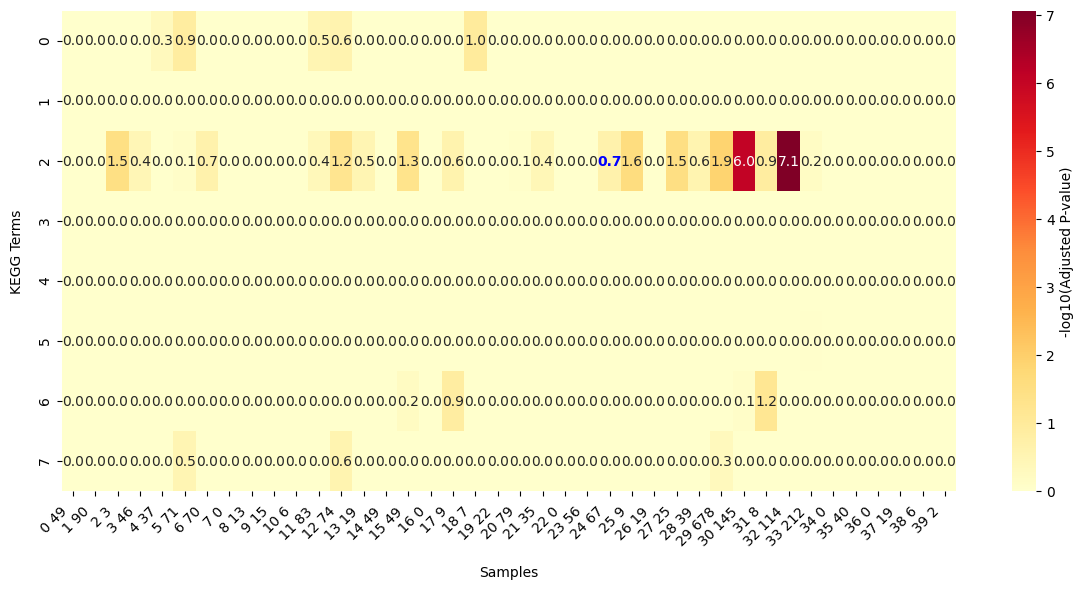

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 转换为 numpy 数组
start = 0
data = np.array(result[start:]).T  # 或 data = np.transpose(result)

# 绘制热图
plt.figure(figsize=(12, 6))  # 适当增加高度以适应旋转的标签

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    xticklabels=[f" {i} {str(number[i])} " for i in range(len(result[start:]))],
    yticklabels=[f"{j}" for j in range(len(important_GO))],
    cbar_kws={"label": "-log10(Adjusted P-value)"}  # 修改颜色条标签
)

# 旋转横轴标签45度，并右对齐
ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=45, 
                  ha='right',
                  fontsize=10)

# 调整纵轴标签字体
ax.set_yticklabels(ax.get_yticklabels(), 
                  fontsize=10)

# 添加标题和轴标签
# plt.title("Transposed Heatmap (8x12)", pad=20)
plt.xlabel("Samples", labelpad=10)
plt.ylabel("KEGG Terms", labelpad=10)

for text in ax.texts:
    # 获取当前文本的位置（行和列）
    row, col = text.get_position()
    # if int(row) == 2 and int(col) == 3:  # 第3行第4列（索引从0开始）
    if buer[start:][int(row)][int(col)] == 1:
        text.set_color('blue')  # 修改颜色
        text.set_weight('bold')  # 可选：加粗
# 确保标签不被截断
plt.tight_layout()

plt.show()

In [14]:
sample_index = 15
GO_index = -2
use = CDH_list[sample_index]['nab']
effected = use[0]+use[1]+use[3]
print(set(use[0])&set(gene_sets[important_GO[GO_index]]), set(use[1]) & set(gene_sets[important_GO[GO_index]]), set(use[3]) & set(gene_sets[important_GO[GO_index]]))
for iiia in set(effected) & set(gene_sets[important_GO[GO_index]]):
    print(iiia)
print(CDH_list[sample_index]['mutation'])
set(effected) & set(gene_sets[important_GO[GO_index]]), CDH_list[sample_index]['mutation'], important_GO[GO_index]

{'GABRB1', 'GABRB2', 'PRKCA', 'CACNA1A', 'PRKACA'} set() set()
GABRB1
GABRB2
PRKCA
CACNA1A
PRKACA
GABRB3


({'CACNA1A', 'GABRB1', 'GABRB2', 'PRKACA', 'PRKCA'},
 'GABRB3',
 'Serotonergic synapse')

In [18]:
sample_index = 28
GO_index = 2
use = CDH_list[sample_index]['nab']
effected = use[0]+use[1]+use[3]
print(set(use[0])&set(gene_sets[important_GO[GO_index]]), set(use[1]) & set(gene_sets[important_GO[GO_index]]), set(use[3]) & set(gene_sets[important_GO[GO_index]]))
for iiia in set(effected) & set(gene_sets[important_GO[GO_index]]):
    print(iiia)
print(CDH_list[sample_index]['mutation'])
set(effected) & set(gene_sets[important_GO[GO_index]]), CDH_list[sample_index]['mutation'], important_GO[GO_index]

{'PRKCA', 'JAG1'} {'SRC'} set()
SRC
PRKCA
JAG1
SDCBP2


({'JAG1', 'PRKCA', 'SRC'}, 'SDCBP2', 'Chemical carcinogenesis')

In [44]:
sample_index = 28
GO_index = 2
use = CDH_list[sample_index]['nab']
effected = use[0]+use[1]+use[3]
print(set(use[0])&set(gene_sets[important_GO[GO_index]]), set(use[1]) & set(gene_sets[important_GO[GO_index]]), set(use[3]) & set(gene_sets[important_GO[GO_index]]))
for iiia in set(effected) & set(gene_sets[important_GO[GO_index]]):
    print(iiia)
print(CDH_list[sample_index]['mutation'])
set(effected) & set(gene_sets[important_GO[GO_index]]), CDH_list[sample_index]['mutation'], important_GO[GO_index]


{'PRKCA', 'JAG1'} {'SRC'} set()
PRKCA
SRC
JAG1
SDCBP2


({'JAG1', 'PRKCA', 'SRC'}, 'SDCBP2', 'Chemical carcinogenesis')

In [25]:
set(['THBS1' ,'ITGA2B' ,'GP1BA' ,'THBS1' ,'MIR27A']) & set(gene_sets[important_GO[2]])

{'ITGA2B'}

In [ ]:
import gseapy as gp
import math
gene_sets = {}
import pandas as pd
# samples = pd.read_csv('../manything/ASD_use.csv')
# samples = samples[samples['PrimaryPhenotype'] == 'Autism (ASD)']
# samples['PrimaryPhenotype'].value_counts(), samples.shape
with open("../manything/KEGG_2021_Human.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis

# important_GO = [
#     "Amino acid metabolism",
#     "Neuroactive ligand-receptor interaction",
#     "Cytokine-cytokine receptor interaction",
#     "Calcium signaling pathway",
#     "Synaptic vesicle cycle"
# ]
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
result = []
number = []

ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
buer = []

nnnn = 30
import json
with open('../manything/disease_onlyp_LGS.json', 'r') as f:
    CDH_list = json.load(f)

# for index, sample in enumerate(CDH_list):
#     use_gene = list(G.neighbors(sample['mutation']))
#     # if any(item not in sample['nab'][0]+sample['nab'][1]+sample['nab'][2]+sample['nab'][3] for item in use_gene):
#     #     print('err0')
#     #     break

#     for class_index in range(len(sample['nab'])):
#         CDH_list[index]['nab'][class_index] = [gene for gene in CDH_list[index]['nab'][class_index] if gene in use_gene]

for idx, sample in enumerate(CDH_list):
    sample_result = []
    samplep = sample['nab']
    use_gene = samplep[0] + samplep[1] + samplep[3]# + [samples.iloc[idx]['Gene.refGene']]
    # print(len(use_gene))
    geneuse = sample['mutation']
    number.append(len(use_gene))
    if len(use_gene) == 0:
        result.append([0 for _ in range(len(important_GO))])

        sample_buer = []
        # print(len(use_gene))
        for GO in important_GO:
            
            if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
                sample_buer.append(1)
                print(geneuse, GO, idx)
            else:
                sample_buer.append(0)  # 未找到，填充 0
        buer.append(sample_buer)
        
        continue
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    if len(pandas_use) == 0:
        print(idx)
        result.append([0 for _ in range(len(important_GO))])
        sample_buer = []
        for GO in important_GO:
            
            if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
                sample_buer.append(1)
                print(geneuse, GO, idx)
            else:
                sample_buer.append(0)  # 未找到，填充 0
        buer.append(sample_buer)



        
        continue
    for GO in important_GO:
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            
            sample_result.append(-math.log10(p_value))

            # p_value = item['Overlap'].values[0]  # 提取 P-value
            
            # sample_result.append(int(p_value.split('/')[0]))
        else:
            sample_result.append(0)  # 未找到，填充 0
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)


    sample_buer = []
    # print(len(use_gene))
    for GO in important_GO:
        
        if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
            sample_buer.append(1)
            print(geneuse, GO, idx)
        else:
            sample_buer.append(0)  # 未找到，填充 0
    buer.append(sample_buer)
    if len(buer) == nnnn:
        break

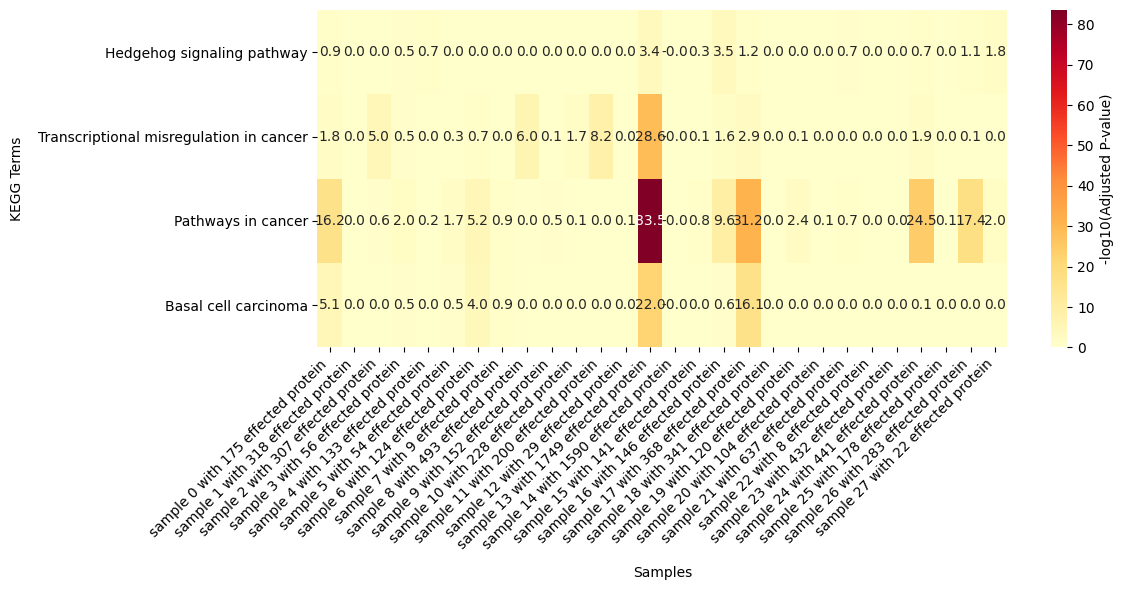

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 转换为 numpy 数组
start = 0
data = np.array(result[start:]).T  # 或 data = np.transpose(result)

# 绘制热图
plt.figure(figsize=(12, 6))  # 适当增加高度以适应旋转的标签

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    xticklabels=[f"sample {i} with {str(number[i])} effected protein" for i in range(len(result[start:]))],
    yticklabels=[f"{j}" for j in important_GO],
    cbar_kws={"label": "-log10(Adjusted P-value)"}  # 修改颜色条标签
)

# 旋转横轴标签45度，并右对齐
ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=45, 
                  ha='right',
                  fontsize=10)

# 调整纵轴标签字体
ax.set_yticklabels(ax.get_yticklabels(), 
                  fontsize=10)

# 添加标题和轴标签
# plt.title("Transposed Heatmap (8x12)", pad=20)
plt.xlabel("Samples", labelpad=10)
plt.ylabel("KEGG Terms", labelpad=10)

for text in ax.texts:
    # 获取当前文本的位置（行和列）
    row, col = text.get_position()
    # if int(row) == 2 and int(col) == 3:  # 第3行第4列（索引从0开始）
    if buer[start:][int(row)][int(col)] == 1:
        text.set_color('blue')  # 修改颜色
        text.set_weight('bold')  # 可选：加粗
# 确保标签不被截断
plt.tight_layout()

plt.show()

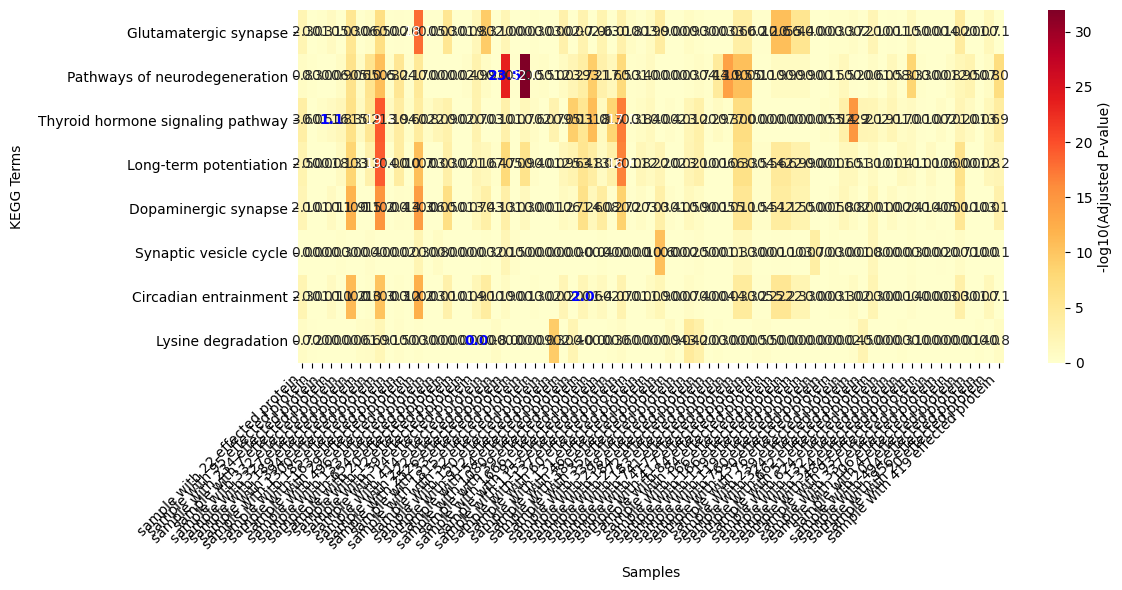

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 转换为 numpy 数组
start = 0
data = np.array(result[start:]).T  # 或 data = np.transpose(result)

# 绘制热图
plt.figure(figsize=(12, 6))  # 适当增加高度以适应旋转的标签

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    xticklabels=[f"sample with {str(number[i])} effected protein" for i in range(len(result[start:]))],
    yticklabels=[f"{j}" for j in important_GO],
    cbar_kws={"label": "-log10(Adjusted P-value)"}  # 修改颜色条标签
)

# 旋转横轴标签45度，并右对齐
ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=45, 
                  ha='right',
                  fontsize=10)

# 调整纵轴标签字体
ax.set_yticklabels(ax.get_yticklabels(), 
                  fontsize=10)

# 添加标题和轴标签
# plt.title("Transposed Heatmap (8x12)", pad=20)
plt.xlabel("Samples", labelpad=10)
plt.ylabel("KEGG Terms", labelpad=10)

for text in ax.texts:
    # 获取当前文本的位置（行和列）
    row, col = text.get_position()
    # if int(row) == 2 and int(col) == 3:  # 第3行第4列（索引从0开始）
    if buer[start:][int(row)][int(col)] == 1:
        text.set_color('blue')  # 修改颜色
        text.set_weight('bold')  # 可选：加粗
# 确保标签不被截断
plt.tight_layout()

plt.show()

In [39]:
sample_index = 29
GO_index = 2
use = ASD_list[sample_index]
effected = use[0]+use[1]+use[3]
print(set(use[0])&set(gene_sets[important_GO[GO_index]]), set(use[1]) & set(gene_sets[important_GO[GO_index]]), set(use[3]) & set(gene_sets[important_GO[GO_index]]))
for iiia in set(effected) & set(gene_sets[important_GO[GO_index]]):
    print(iiia)
print(samples.iloc[sample_index]['Gene.refGene'])
set(effected) & set(gene_sets[important_GO[GO_index]]), samples.iloc[sample_index]['Gene.refGene'], important_GO[GO_index]


NameError: name 'ASD_list' is not defined

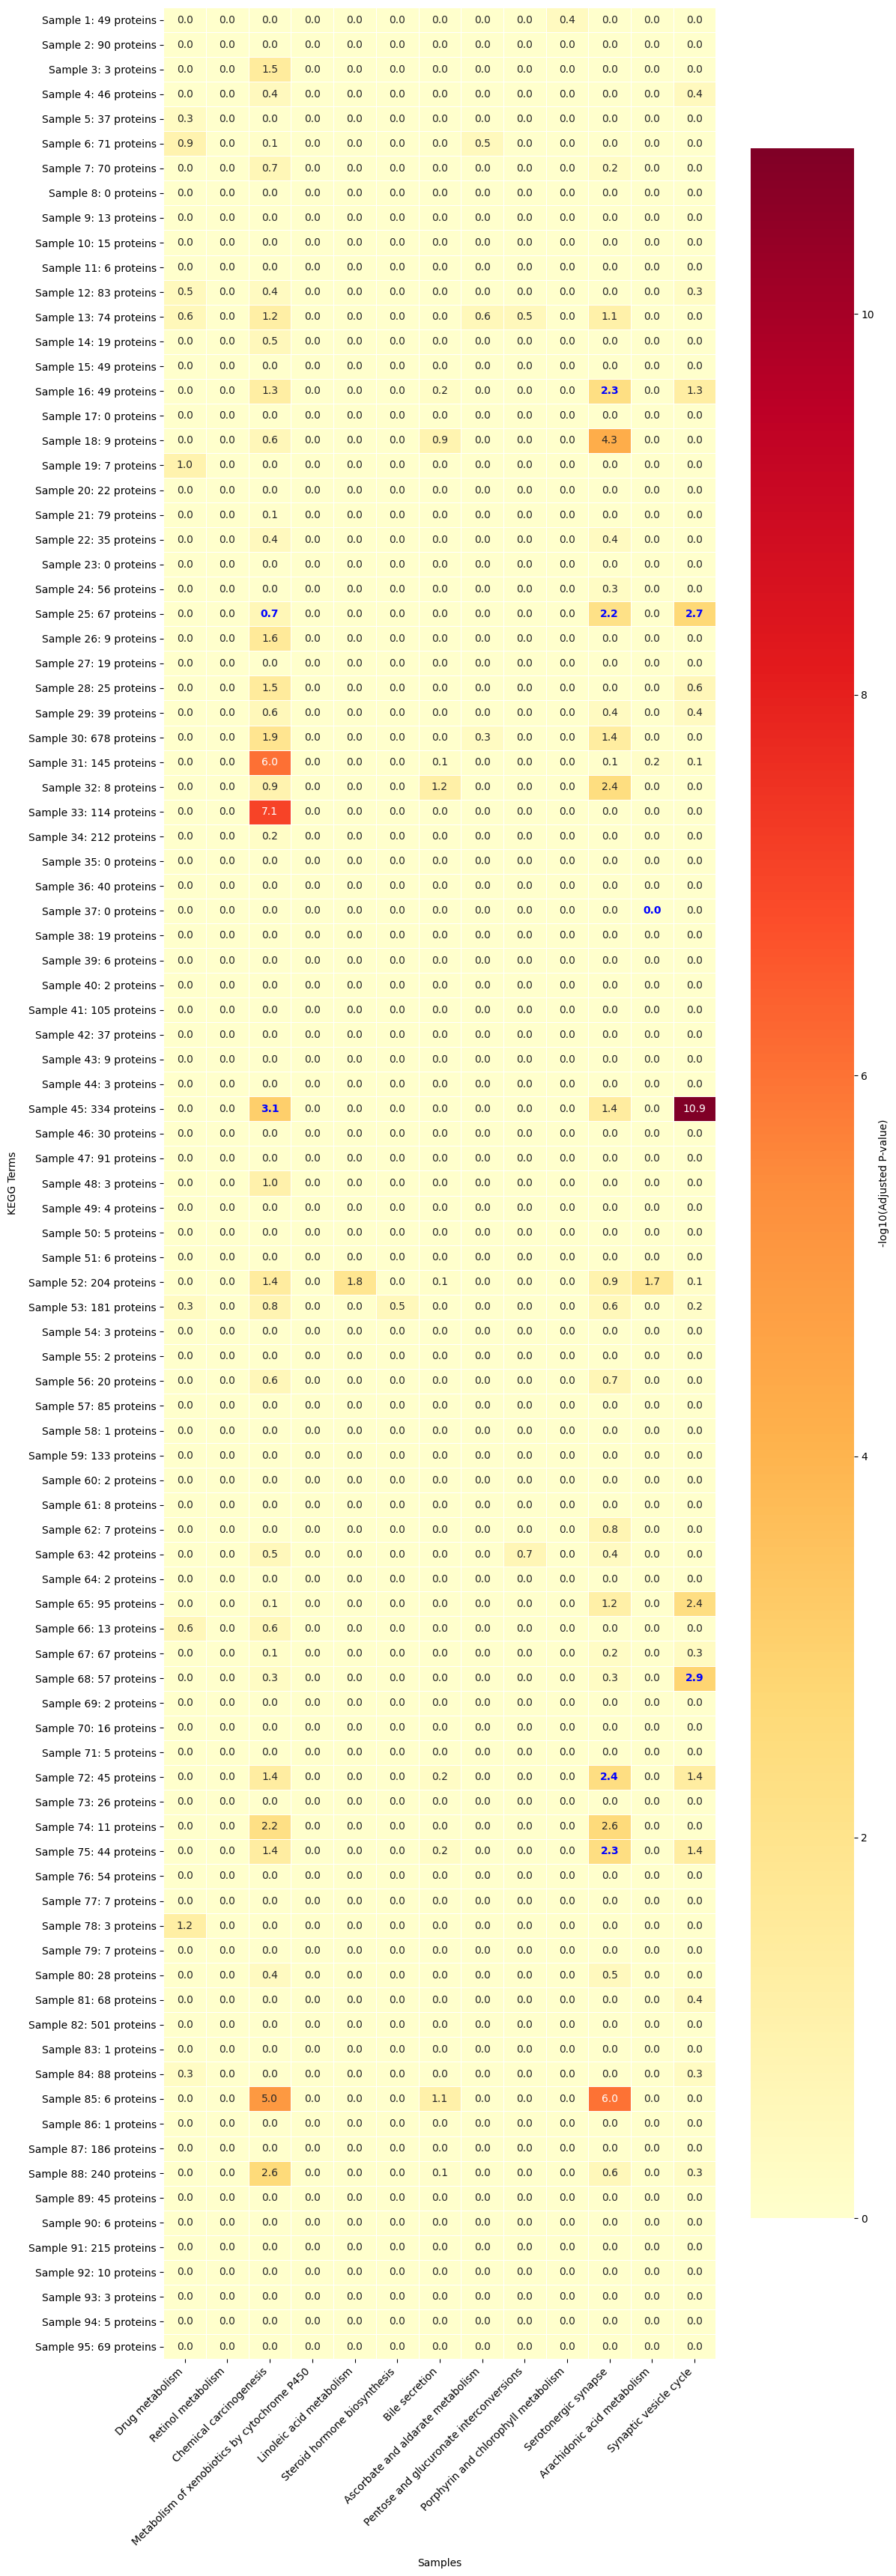

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 result 是原始数据（行=样本，列=GO/KEGG Terms）
start = 0
data = np.array(result[start:])  # 转置数据（行=Terms，列=样本）

# --- 自适应高度计算 ---
# 基础高度（每个Term分配0.3英寸，最小6英寸）
base_height = 6  
term_height = 0.3  # 每个Term的高度（英寸）
dynamic_height = base_height + term_height * data.shape[0]  # 根据行数调整

# 创建画布（宽度固定，高度动态）
plt.figure(figsize=(12, dynamic_height))

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    yticklabels=[f"Sample {i+1}: {number[i]} proteins" for i in range(len(result[start:]))],
    xticklabels=important_GO[start:],  # 直接使用GO/KEGG名称列表
    cbar_kws={"label": "-log10(Adjusted P-value)"},
    linewidths=0.5  # 添加细线分隔单元格
)

# 调整标签样式
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    ha='right',
    fontsize=10
)
ax.set_yticklabels(
    ax.get_yticklabels(), 
    fontsize=10,
    rotation=0  # 保证纵轴标签水平显示
)

# 设置轴标签
plt.xlabel("Samples", labelpad=10)
plt.ylabel("KEGG Terms", labelpad=10)

# 高亮特定单元格（根据buer矩阵）
for text in ax.texts:
    row, col = map(int, text.get_position())
    if buer[start:][col][row] == 1:  # 注意转置后行列索引变化
        text.set_color('blue')
        text.set_weight('bold')

# 自动调整布局
plt.tight_layout()
plt.show()

In [27]:
len(buer)

73

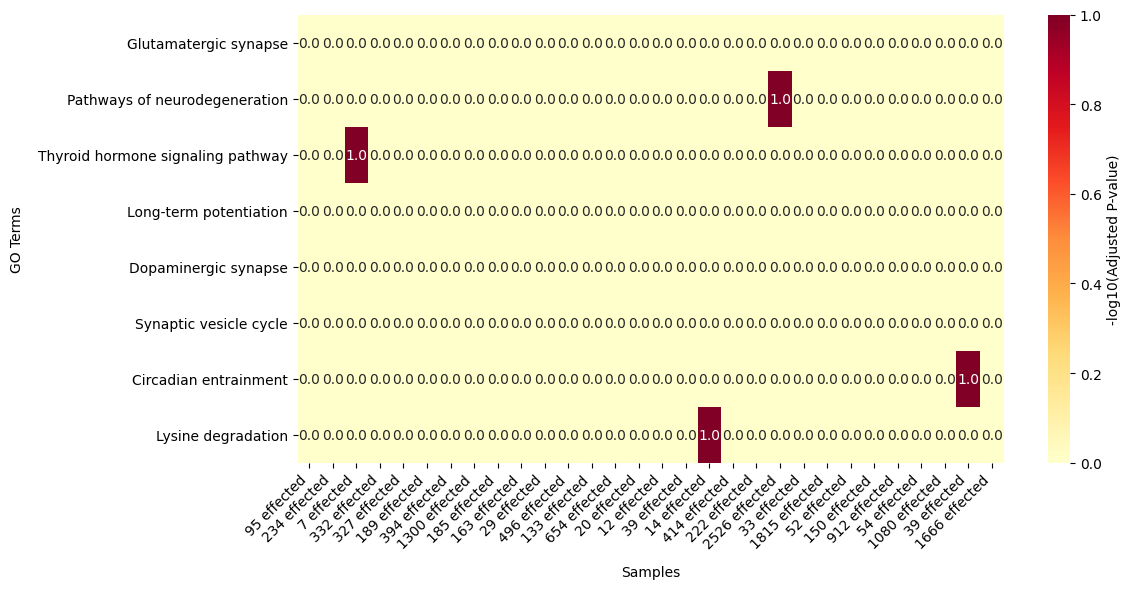

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 转换为 numpy 数组
data = np.array(buer).T  # 或 data = np.transpose(result)

# 绘制热图
plt.figure(figsize=(12, 6))  # 适当增加高度以适应旋转的标签

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    xticklabels=[f"{str(number[i])} effected" for i in range(len(result))],
    yticklabels=[f"{j}" for j in important_GO],
    cbar_kws={"label": "-log10(Adjusted P-value)"}  # 修改颜色条标签
)

# 旋转横轴标签45度，并右对齐
ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=45, 
                  ha='right',
                  fontsize=10)

# 调整纵轴标签字体
ax.set_yticklabels(ax.get_yticklabels(), 
                  fontsize=10)

# 添加标题和轴标签
# plt.title("Transposed Heatmap (8x12)", pad=20)
plt.xlabel("Samples", labelpad=10)
plt.ylabel("GO Terms", labelpad=10)

# 确保标签不被截断
plt.tight_layout()

plt.show()

In [39]:
sample = ASD_list[0]
use_gene = sample[0] + sample[1] + sample[3]
# print(len(use_gene))
# number.append(len(use_gene))
enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
             gene_sets=gene_sets,
             organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
             outdir=None, # don't write to disk
            )
pandas_use = enr.results
ooo = 7
item = pandas_use[pandas_use['Term'] == important_GO[ooo]]
print(important_GO[ooo])
if not item.empty:  # 检查是否找到匹配项
    p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
    print(-math.log10(p_value))
else:
    print(0)  # 未找到，填充 0

Lysine degradation
0.2375864067943114


In [4]:
import networkx as nx

# 从 GML 文件读取图
G = nx.read_gml('../manything/graph_ppi.gml')

In [21]:
import pandas as pd
samples = pd.read_csv('../manything/ASD_use.csv')
samples = samples[samples['PrimaryPhenotype'] == 'Autism (ASD)']
samples['PrimaryPhenotype'].value_counts(), samples.shape

/tmp/ipykernel_438679/222384378.py:2: DtypeWarning: Columns (15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('../manything/ASD_use.csv')


(PrimaryPhenotype
 Autism (ASD)    4572
 Name: count, dtype: int64,
 (4572, 169))

In [31]:
def get_nerb(node_a, G):
    if node_a in G:
        connected_nodes = list(G.neighbors(node_a))
    else:
        connected_nodes = []
    return connected_nodes

In [36]:
# samples.iloc[1]['Gene.refGene']
i = 2
set(get_nerb(samples.iloc[i + 1]['Gene.refGene'], G)) == set(ASD_list[i][0] + ASD_list[i][1] + ASD_list[i][2] + ASD_list[i][3])

True

In [51]:
important_GO

['Glutamatergic synapse',
 'Pathways of neurodegeneration',
 'Thyroid hormone signaling pathway',
 'Long-term potentiation',
 'Dopaminergic synapse',
 'Synaptic vesicle cycle',
 'Circadian entrainment',
 'Lysine degradation']

In [3]:
import gseapy as gp
import math
gene_sets = {}
with open("../manything/CORUM.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis
ssss = {}
important_GO = []
for key in gene_sets.keys():
    ssss[key] = []
for use_gene in importants:
    sample_result = []
    # use_gene = sample[0] + sample[1] + sample[3]
    # print(len(use_gene))
    number.append(len(use_gene))
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)
    # if len(result) == 30:
    #     break
# Calculate the average for each GO term in ssss
average_scores = {go: (sum(scores) / len(scores) if scores else 0) for go, scores in ssss.items()}

# Find the top 5 GO terms with the highest average scores
top_5_go = sorted(average_scores.items(), key=lambda item: item[1], reverse=True)[:8]

# Print the results
important_GO = []
for go_term, avg_score in top_5_go:
    print("GO term:", go_term, "Average score:", avg_score)
    important_GO.append(go_term)

NameError: name 'importants' is not defined

In [115]:
top_5_go = sorted(average_scores.items(), key=lambda item: item[1], reverse=True)[:15]

# Print the results
important_GO = []
for go_term, avg_score in top_5_go:
    print("GO term:", go_term, "Average score:", avg_score)
    important_GO.append(go_term)
important_GO

GO term: LARC complex (LCR-associated remodeling complex) (human) Average score: 2.383374632678962
GO term: SWI-SNF chromatin remodeling-related-BRCA1 complex (human) Average score: 2.225616808359315
GO term: BRM-SIN3A complex (human) Average score: 2.1867535633170743
GO term: BRG1-SIN3A complex (human) Average score: 2.1066607538259166
GO term: BAF complex (human) Average score: 2.088443123604986
GO term: SIN3-ING1b complex II (human) Average score: 2.024210070824761
GO term: WINAC complex (human) Average score: 2.0179832249183103
GO term: ALL-1 supercomplex (human) Average score: 1.9996129994307044
GO term: BRM-SIN3A-HDAC complex (human) Average score: 1.9131041546663483
GO term: NuA4/Tip60-HAT complex A (human) Average score: 1.8776526878680329
GO term: p300-CBP-p270-SWI/SNF complex (human) Average score: 1.8555636104434226
GO term: DMAP1-associated complex (human) Average score: 1.6705943875392932
GO term: RSmad complex (human) Average score: 1.6426144935898315
GO term: EBAFb compl

['LARC complex (LCR-associated remodeling complex) (human)',
 'SWI-SNF chromatin remodeling-related-BRCA1 complex (human)',
 'BRM-SIN3A complex (human)',
 'BRG1-SIN3A complex (human)',
 'BAF complex (human)',
 'SIN3-ING1b complex II (human)',
 'WINAC complex (human)',
 'ALL-1 supercomplex (human)',
 'BRM-SIN3A-HDAC complex (human)',
 'NuA4/Tip60-HAT complex A (human)',
 'p300-CBP-p270-SWI/SNF complex (human)',
 'DMAP1-associated complex (human)',
 'RSmad complex (human)',
 'EBAFb complex (human)',
 'NCOR1 complex (human)']

In [116]:
import json
nnnn = 30
with open('../manything/pathway_analyse.json', 'r') as f:
    ASD_list = json.load(f)
result = []
for sample in ASD_list:
    sample_result = []
    use_gene = sample[0] + sample[1] + sample[3]
    print(len(use_gene))
    number.append(len(use_gene))
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    for GO in important_GO:
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            sample_result.append(-math.log10(p_value))
        else:
            sample_result.append(0)  # 未找到，填充 0
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)
    if len(result) == nnnn:
        break
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
buer = []
for idx, sample in enumerate(ASD_list):
    sample_buer = []
    # print(len(use_gene))
    pandas_use = enr.results
    geneuse = samples.iloc[idx]['Gene.refGene']
    for GO in important_GO:
        
        if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
            sample_buer.append(1)
            print(geneuse, GO, idx)
        else:
            sample_buer.append(0)  # 未找到，填充 0
    buer.append(sample_buer)
    if len(buer) == nnnn:
        break

95
234
7
332
327
189
394
1300
185
163
29
496
133
654
20
12
39
14
414
222
2526
33
1815
52
150
912
54
1080
39
1666


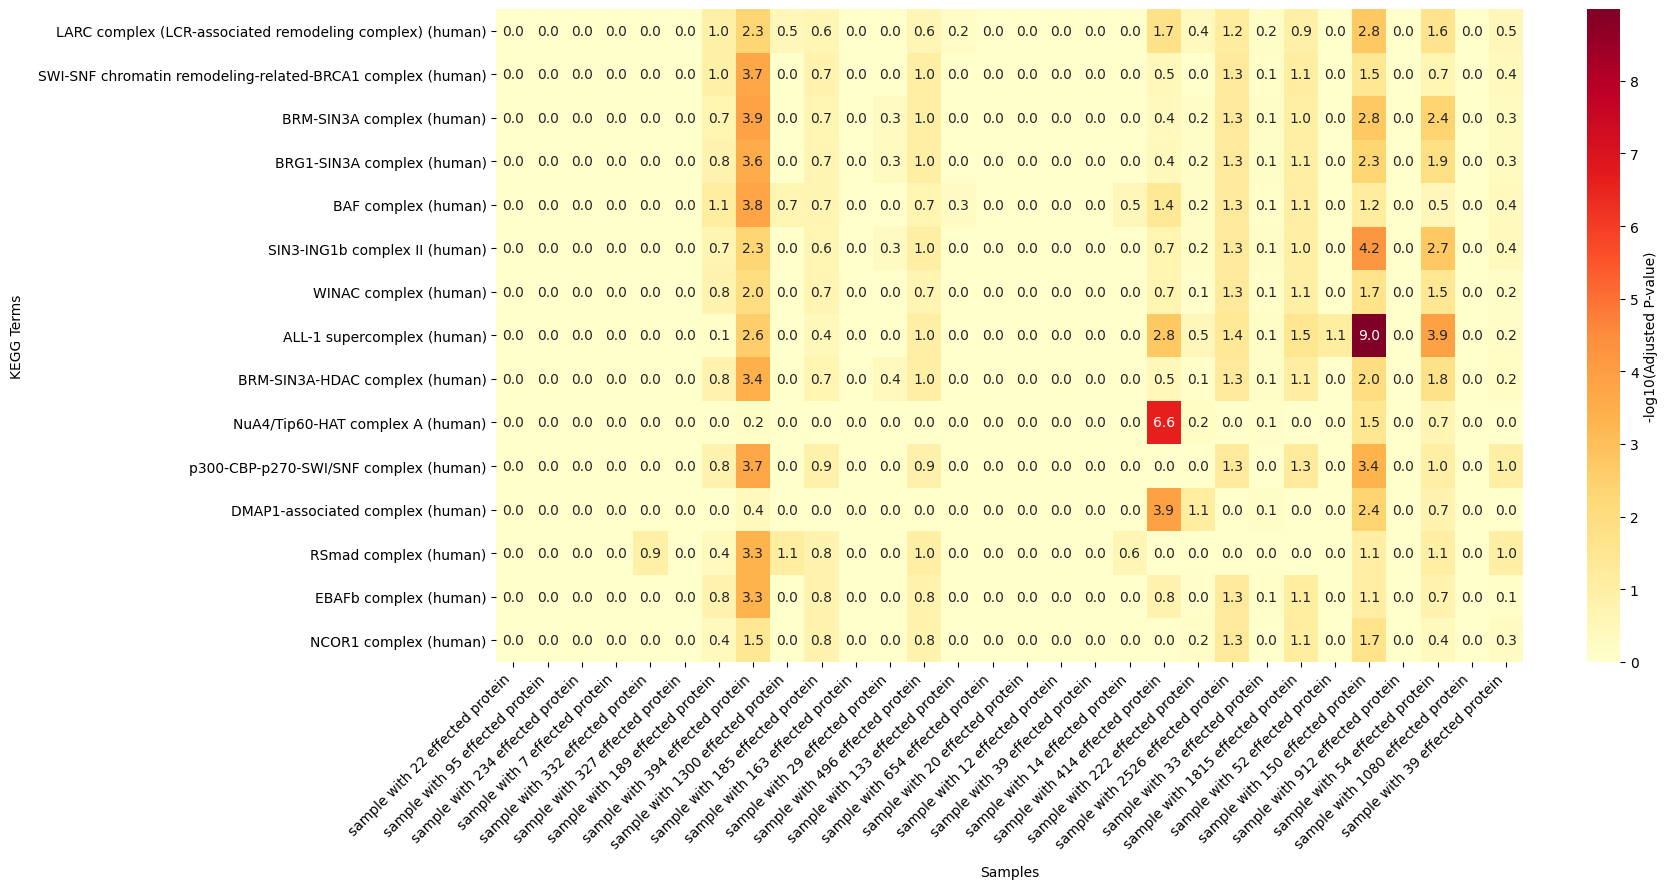

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 转换为 numpy 数组
start = 0
data = np.array(result[start:]).T  # 或 data = np.transpose(result)

# 绘制热图
plt.figure(figsize=(18, 9))  # 适当增加高度以适应旋转的标签

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    xticklabels=[f"sample with {str(number[i])} effected protein" for i in range(len(result[start:]))],
    yticklabels=[f"{j}" for j in important_GO],
    cbar_kws={"label": "-log10(Adjusted P-value)"}  # 修改颜色条标签
)

# 旋转横轴标签45度，并右对齐
ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=45, 
                  ha='right',
                  fontsize=10)

# 调整纵轴标签字体
ax.set_yticklabels(ax.get_yticklabels(), 
                  fontsize=10)

# 添加标题和轴标签
# plt.title("Transposed Heatmap (8x12)", pad=20)
plt.xlabel("Samples", labelpad=10)
plt.ylabel("KEGG Terms", labelpad=10)

for text in ax.texts:
    # 获取当前文本的位置（行和列）
    row, col = text.get_position()
    # if int(row) == 2 and int(col) == 3:  # 第3行第4列（索引从0开始）
    if buer[start:][int(row)][int(col)] == 1:
        text.set_color('blue')  # 修改颜色
        text.set_weight('bold')  # 可选：加粗
# 确保标签不被截断
plt.tight_layout()

plt.show()

IndexError: list index out of range

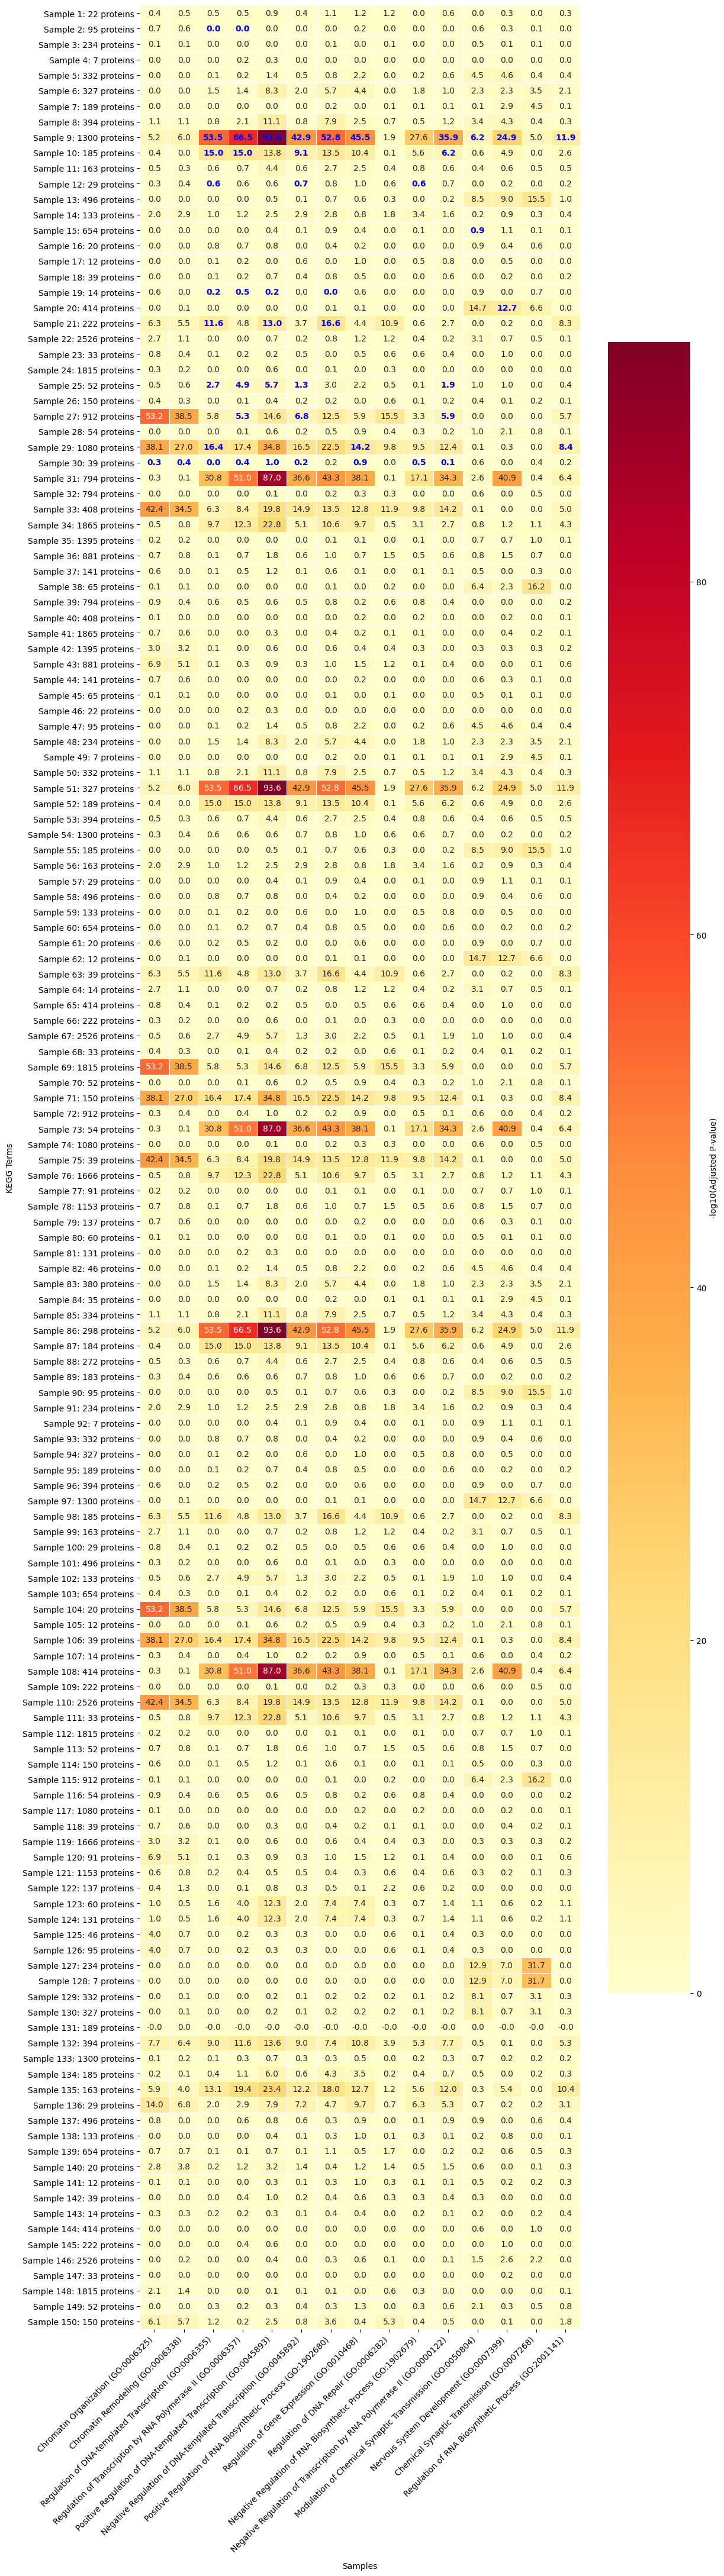

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 result 是原始数据（行=样本，列=GO/KEGG Terms）
start = 0
data = np.array(result)  # 转置数据（行=Terms，列=样本）

# --- 自适应高度计算 ---
# 基础高度（每个Term分配0.3英寸，最小6英寸）
base_height = 6  
term_height = 0.3  # 每个Term的高度（英寸）
dynamic_height = base_height + term_height * data.shape[0]  # 根据行数调整

# 创建画布（宽度固定，高度动态）
plt.figure(figsize=(12, dynamic_height))

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    yticklabels=[f"Sample {i+1}: {number[i]} proteins" for i in range(len(result[start:]))],
    xticklabels=important_GO[start:],  # 直接使用GO/KEGG名称列表
    cbar_kws={"label": "-log10(Adjusted P-value)"},
    linewidths=0.5  # 添加细线分隔单元格
)

# 调整标签样式
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    ha='right',
    fontsize=10
)
ax.set_yticklabels(
    ax.get_yticklabels(), 
    fontsize=10,
    rotation=0  # 保证纵轴标签水平显示
)

# 设置轴标签
plt.xlabel("Samples", labelpad=10)
plt.ylabel("KEGG Terms", labelpad=10)

# 高亮特定单元格（根据buer矩阵）
for text in ax.texts:
    row, col = map(int, text.get_position())
    if buer[col][row] == 1:  # 注意转置后行列索引变化
        text.set_color('blue')
        text.set_weight('bold')

# 自动调整布局
plt.tight_layout()
plt.show()

In [12]:
import gseapy as gp
import math
gene_sets = {}
import pandas as pd
samples = pd.read_csv('../manything/ASD_use.csv')
samples = samples[samples['PrimaryPhenotype'] == 'Autism (ASD)']
samples['PrimaryPhenotype'].value_counts(), samples.shape
with open("../manything/CORUM.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

for sample_index in range(len(ASD_list)):
    sample = ASD_list[sample_index]
    effected = sample[0] + sample[1] + sample[3]
    gene_with_mutation = {}
    for pathway in gene_sets.keys():
        if samples.iloc[sample_index]['Gene.refGene'] in gene_sets[pathway]:
            gene_with_mutation[pathway] = gene_sets[pathway]
    if len(gene_with_mutation) != 0 :
        print(samples.iloc[sample_index]['Gene.refGene'], sample_index)


/tmp/ipykernel_2983813/1051916321.py:5: DtypeWarning: Columns (15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('../manything/ASD_use.csv')


DAG1 4
MPDZ 12
TUBA1A 21
POLR2A 28
TOP1 32
ELK1 33
AP3B2 38
INPP5K 56
ITK 57
MOV10 59


In [13]:
import gseapy as gp
import math
import json
gene_sets = {}
import pandas as pd
from gseapy import barplot, dotplot
with open('../manything/pathway_analyse1.json', 'r') as f:
    ASD_list = json.load(f)
samples = pd.read_csv('../manything/ASD_use.csv')
samples = samples[samples['PrimaryPhenotype'] == 'Autism (ASD)']
samples['PrimaryPhenotype'].value_counts(), samples.shape
with open("../manything/CORUM.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes
#21的三个蛋白复合物两个与神经退行疾病相关
sample_index = 28
sample = ASD_list[sample_index]
effected = sample[0] + sample[1] + sample[3]
gene_with_mutation = {}
for pathway in gene_sets.keys():
    if samples.iloc[sample_index]['Gene.refGene'] in gene_sets[pathway]:
        gene_with_mutation[pathway] = gene_sets[pathway]
len(gene_with_mutation)
enr = gp.enrichr(gene_list=effected, # or "./tests/data/gene_list.txt",
             gene_sets=gene_with_mutation,
             organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
             outdir=None, # don't write to disk
            )
enr.results.head()

/tmp/ipykernel_276271/2349228147.py:9: DtypeWarning: Columns (15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('../manything/ASD_use.csv')


Gene_set                                               Term Overlap  \
0  gs_ind_0  Actin-ribonucleoprotein complex (POLR2A, GTF2F...     2/3   
1  gs_ind_0                 BRCA1-BARD1-POLR2A complex (human)     2/3   
2  gs_ind_0            BRCA1-RNA polymerase II complex (human)   14/26   
3  gs_ind_0       BRCA1-core RNA polymerase II complex (human)    6/13   
4  gs_ind_0                         CSA-POLIIa complex (human)    7/14   

    P-value  Adjusted P-value  Odds Ratio  Combined Score  \
0  0.523932          0.949685    1.596491        1.031962   
1  0.523932          0.949685    1.596491        1.031962   
2  0.484046          0.949685    1.127324        0.817958   
3  0.763937          0.949685    0.786973        0.211908   
4  0.661929          0.949685    0.929412        0.383473   

                                               Genes  
0                                      GTF2F1;HNRNPU  
1                                        BRCA1;BARD1  
2  GTF2H1;TBP;POLR2B;POLR2I;GTF2E2;BRCA1;POLR2L;G...  
3           POLR2B;POLR2I;BRCA1;POLR2L;POLR2E;POLR2K  
4           COPS5;RBX1;COPS4;COPS7A;DDB1;COPS6;CUL4A

In [14]:
enr.results['Term'].tolist()

['Actin-ribonucleoprotein complex (POLR2A, GTF2F1, HNRNPU) (human)',
 'BRCA1-BARD1-POLR2A complex (human)',
 'BRCA1-RNA polymerase II complex (human)',
 'BRCA1-core RNA polymerase II complex (human)',
 'CSA-POLIIa complex (human)',
 'HES1 promoter corepressor complex (human)',
 'HES1 promoter-Notch enhancer complex (human)',
 'Integrator-RNAPII complex (human)',
 'POLR2A-CCNT1-CDK9-NCL-LEM6-CPSF2 complex (human)',
 'Pre-initiation complex (PIC) (human)',
 'RNA pol II containing coactivator complex Tat-SF (human)',
 'RNA polymerase II (RNAPII) (human)',
 'RNA polymerase II complex, chromatin structure modifying (human)',
 'RNA polymerase II core complex (human)',
 'RNA polymerase II holoenzyme complex (human)',
 'SMN-PolII-RHA complex (human)']

In [9]:
GOOO = 'RICH1/AMOT polarity complex, Flag-Amot precipitated (human)'
for nnna in gene_sets[GOOO]:
    print(nnna)

MPP5
AMOTL1
INADL
AMOTL2
ARHGAP17
MPDZ
MPP7
AMOT


In [17]:
import gseapy as gp
import math
gene_sets = {}
import pandas as pd
# samples = pd.read_csv('../manything/ASD_use.csv')
# samples = samples[samples['PrimaryPhenotype'] == 'Autism (ASD)']
# samples['PrimaryPhenotype'].value_counts(), samples.shape
with open("../manything/KEGG_2021_Human.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis

# important_GO = [
#     "Amino acid metabolism",
#     "Neuroactive ligand-receptor interaction",
#     "Cytokine-cytokine receptor interaction",
#     "Calcium signaling pathway",
#     "Synaptic vesicle cycle"
# ]
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
result = []
number = []

nnnn = 30
import json
with open('../manything/disease_newPPI.json', 'r') as f:
    ASD_list = json.load(f)
for idx, sample_dict in enumerate(ASD_list):
    sample_result = []
    sample = sample_dict['nab']
    use_gene = sample[0] + sample[1] + sample[3]# + [samples.iloc[idx]['Gene.refGene']]
    if len(use_gene) == 0:
        result.append([0 for _ in range(len(important_GO))])
        number.append(len(use_gene))
        continue
    # print(len(use_gene))
    number.append(len(use_gene))
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    for GO in important_GO:
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            sample_result.append(-math.log10(p_value))
        else:
            sample_result.append(0)  # 未找到，填充 0
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)
    if len(result) == nnnn:
        break
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
buer = []
for idx, sample in enumerate(ASD_list):
    sample_buer = []
    # print(len(use_gene))
    pandas_use = enr.results
    geneuse = sample['mutation']
    for GO in important_GO:
        
        if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
            sample_buer.append(1)
            print(geneuse, GO, idx)
        else:
            sample_buer.append(0)  # 未找到，填充 0
    buer.append(sample_buer)
    if len(buer) == nnnn:
        break

KMT2A Lysine degradation 12
TUBA1A Pathways of neurodegeneration 14
PER1 Circadian entrainment 20


In [16]:
len(number), len(result[start:])

(23, 30)

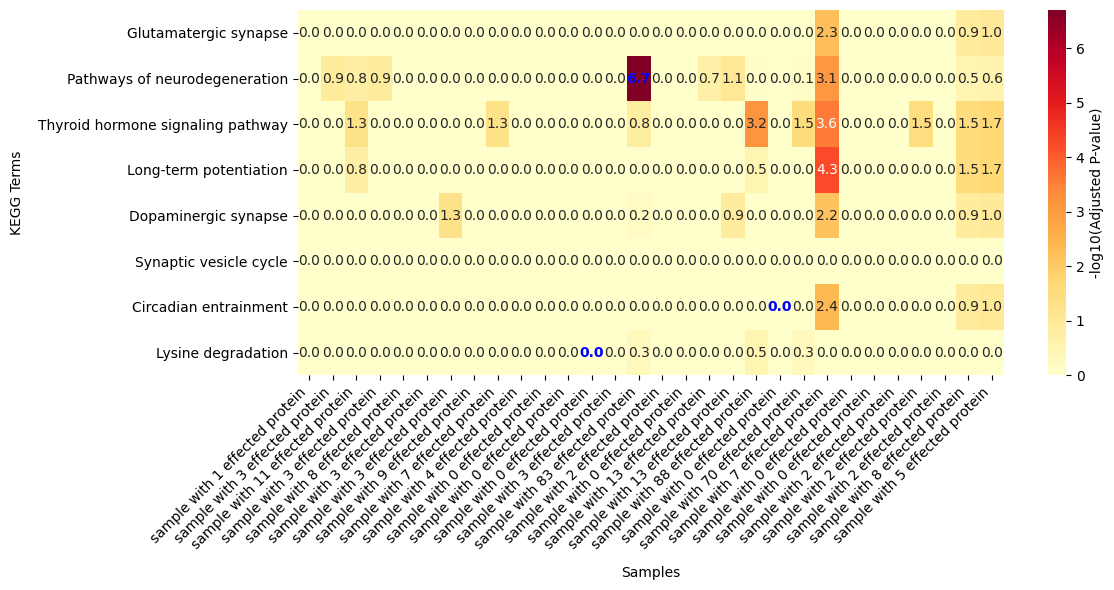

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 转换为 numpy 数组
start = 0
data = np.array(result[start:]).T  # 或 data = np.transpose(result)

# 绘制热图
plt.figure(figsize=(12, 6))  # 适当增加高度以适应旋转的标签

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    xticklabels=[f"sample with {str(number[i])} effected protein" for i in range(len(result[start:]))],
    yticklabels=[f"{j}" for j in important_GO],
    cbar_kws={"label": "-log10(Adjusted P-value)"}  # 修改颜色条标签
)

# 旋转横轴标签45度，并右对齐
ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=45, 
                  ha='right',
                  fontsize=10)

# 调整纵轴标签字体
ax.set_yticklabels(ax.get_yticklabels(), 
                  fontsize=10)

# 添加标题和轴标签
# plt.title("Transposed Heatmap (8x12)", pad=20)
plt.xlabel("Samples", labelpad=10)
plt.ylabel("KEGG Terms", labelpad=10)

for text in ax.texts:
    # 获取当前文本的位置（行和列）
    row, col = text.get_position()
    # if int(row) == 2 and int(col) == 3:  # 第3行第4列（索引从0开始）
    if buer[start:][int(row)][int(col)] == 1:
        text.set_color('blue')  # 修改颜色
        text.set_weight('bold')  # 可选：加粗
# 确保标签不被截断
plt.tight_layout()

plt.show()

In [1]:
import networkx as nx

def get_shortest_paths_to_nodes(G, start, targets):
    # print(start, targets)
    all_paths = []
    min_length = 10
    for target in targets:
        # 获取从 start 到 target 的所有最短路径
        paths = list(nx.all_shortest_paths(G, source=start, target=target))
        all_paths = all_paths + paths
        min_length = min(min_length, len(paths[0]))


    # 获取最短路径的长度
    # 只保留长度等于最短长度的路径
    # print(min_length)
    all_paths = [path for path in all_paths if len(path) == min_length]
    
    return all_paths

In [48]:
get_shortest_paths_to_nodes(G, CDH_list[2]['mutation'], importants[0])

ANKRD24 ['CHD2', 'DNM1', 'FOXG1', 'SLC2A1']
3


[['ANKRD24', 'HNRNPL', 'CHD2'], ['ANKRD24', 'PACSIN1', 'DNM1']]

In [71]:
def keep_unique_values(lst):
    # 使用 set 去重并转换回列表
    unique_values = list(set(lst))
    return unique_values
gene_list = []
for gene in CDH_list[2]['nab'][0]+CDH_list[2]['nab'][1]+CDH_list[2]['nab'][2]+CDH_list[2]['nab'][3]:
    for ii in get_shortest_paths_to_nodes(G, gene, importants[0]):
        # if ii[-1] not in ['DNM1', 'CHD2']:
        #     continue
        for i in ii:
            gene_list.append(i)
        print(ii)
        if len(ii) > 2:
            break
gene_graph = []
for e in keep_unique_values(gene_list):
    print(e)
    gene_graph.append(e)
print(CDH_list[2]['mutation'])
gene_graph.append(CDH_list[2]['mutation'])

['IFT81', 'PLEKHA4', 'CHD2']
['NFKB1', 'H2AC8', 'CHD2']
['PACSIN1', 'DNM1']
['HNRNPL', 'CHD2']
PACSIN1
H2AC8
IFT81
HNRNPL
CHD2
NFKB1
DNM1
PLEKHA4
ANKRD24


In [70]:
importants[0]

['CHD2', 'DNM1', 'FOXG1', 'SLC2A1']

In [72]:
# gene_sets[important_GO[GO_index]]
result_f = []
for gene in gene_graph + ['FOXG1', 'SLC2A1']:
    ggg = []
    for GO_index in range(len(important_GO)):
        if gene in gene_sets[important_GO[GO_index]]:
            ggg.append(1)
        else:
            ggg.append(0)
    result_f.append(ggg)

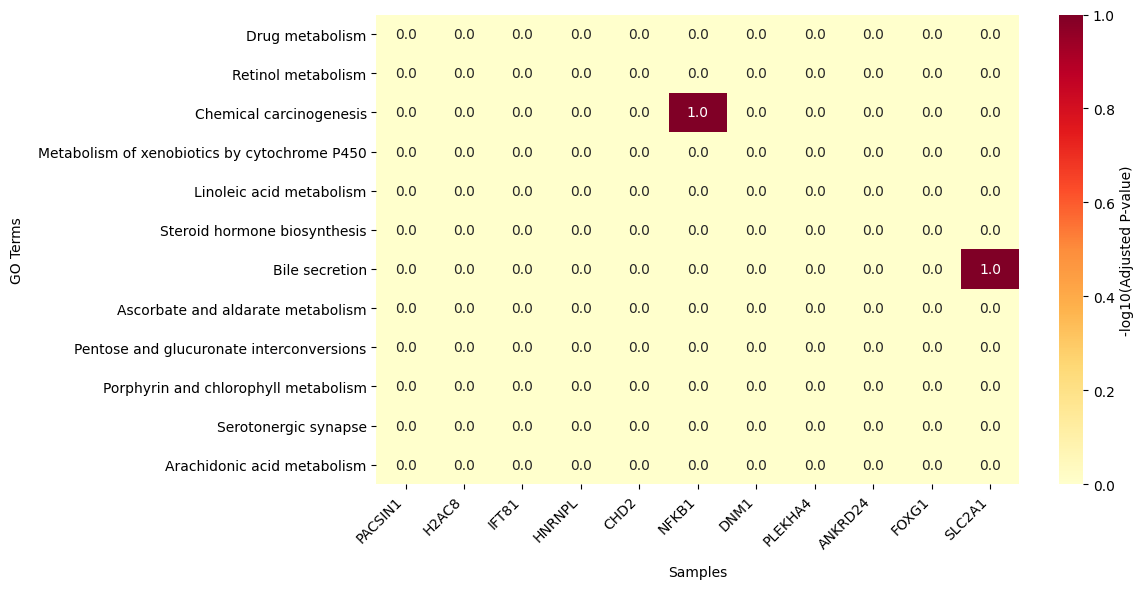

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 转换为 numpy 数组
data = np.array(result_f).T  # 或 data = np.transpose(result)

# 绘制热图
plt.figure(figsize=(12, 6))  # 适当增加高度以适应旋转的标签

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    xticklabels=gene_graph + ['FOXG1', 'SLC2A1'],
    yticklabels=important_GO,
    cbar_kws={"label": "-log10(Adjusted P-value)"}  # 修改颜色条标签
)

# 旋转横轴标签45度，并右对齐
ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=45, 
                  ha='right',
                  fontsize=10)

# 调整纵轴标签字体
ax.set_yticklabels(ax.get_yticklabels(), 
                  fontsize=10)

# 添加标题和轴标签
# plt.title("Transposed Heatmap (8x12)", pad=20)
plt.xlabel("Samples", labelpad=10)
plt.ylabel("GO Terms", labelpad=10)

# 确保标签不被截断
plt.tight_layout()

plt.show()

In [78]:
enr = gp.enrichr(gene_list=importants[0], # or "./tests/data/gene_list.txt",
             gene_sets=gene_sets,
             organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
             outdir=None, # don't write to disk
            )
enr.results.to_csv('/data/lyk/manything/LGS_importantgene1.csv')

In [ ]:
use = CDH_list[2]['mutation']
for ii in range(len(importants[0]))

In [74]:
CDH_list[2]['nab'], importants[0]

([['IFT81'], ['NFKB1', 'PACSIN1'], ['HNRNPL'], []],
 ['CHD2', 'DNM1', 'FOXG1', 'SLC2A1'])

In [26]:
CDH_list[2]['mutation'], importants[0][0], list(G.neighbors(CDH_list[2]['mutation']))

('ANKRD24', 'CHD2', ['HNRNPL', 'NFKB1', 'IFT81', 'PACSIN1'])

In [34]:
list(nx.all_shortest_paths(G, source='IFT81', target=importants[0][0]))

[['IFT81', 'PLEKHA4', 'CHD2'], ['IFT81', 'CTR9', 'CHD2']]

In [18]:
list(nx.all_shortest_paths(G, source=CDH_list[2]['mutation'], target=importants[0][0]))

[['ANKRD24', 'HNRNPL', 'CHD2']]

In [19]:
list(nx.all_shortest_paths(G, source=CDH_list[2]['mutation'], target=importants[0][1]))

[['ANKRD24', 'PACSIN1', 'DNM1']]

In [20]:
list(nx.all_shortest_paths(G, source=CDH_list[2]['mutation'], target=importants[0][2]))

[['ANKRD24', 'HNRNPL', 'TNIP2', 'FOXG1'],
 ['ANKRD24', 'NFKB1', 'TNIP2', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'LARP1', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'AR', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'TCF7L2', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'PTEN', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'KIF20A', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'PPARA', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'RRBP1', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'KPNA1', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'HNRNPUL2', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'CHD4', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'BTAF1', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'FOXO3', 'FOXG1'],
 ['ANKRD24', 'NFKB1', 'FOXO3', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'TP53', 'FOXG1'],
 ['ANKRD24', 'NFKB1', 'TP53', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'RNF4', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'SNX9', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'ATG7', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'ADAR', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'SRF', 'FOXG1'],
 ['ANKRD24', 'NFKB1', 'SRF', 'FOXG1'],
 ['ANKRD24', 'HNRNPL', 'CUX1', 'FOXG1'],
 ['ANKR

In [22]:
list(nx.all_shortest_paths(G, source=CDH_list[2]['mutation'], target=importants[0][3]))

[['ANKRD24', 'HNRNPL', 'JAK2', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'PLEKHA4', 'SLC2A1'],
 ['ANKRD24', 'IFT81', 'PLEKHA4', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'NR2C2', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'NTF3', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'UBE2I', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'PTEN', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'BTF3', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'PPARA', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'WWP1', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'NRP1', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'TYK2', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'PLEKHA7', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'BMI1', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'PTPRS', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'EGFR', 'SLC2A1'],
 ['ANKRD24', 'NFKB1', 'EGFR', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'TP53', 'SLC2A1'],
 ['ANKRD24', 'NFKB1', 'TP53', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'RNF4', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'SOX2', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'VHL', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', 'EPB41', 'SLC2A1'],
 ['ANKRD24', 'HNRNPL', '

In [3]:
import networkx as nx
from pyvis.network import Network

# 创建图
# G = nx.Graph()
# G.add_edges_from([(1, 2), (1, 3), (2, 4), (3, 4), (4, 5)])

# 使用 pyvis 创建网络图
net = Network(notebook=True)

# 将 networkx 图添加到 pyvis 网络
net.from_nx(G)

# 生成 HTML 文件
output_file = "../manything/test_graph.html"
net.show(output_file)

print(f"Graph has been saved to {output_file}.")

../manything/test_graph.html
Graph has been saved to ../manything/test_graph.html.


In [5]:
import torch

OSError: [Errno 107] Transport endpoint is not connected